In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
from math import sqrt

%matplotlib inline
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from IPython.core.display import display

from scipy.stats import uniform

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV

In [3]:
path = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
train.shape, test.shape

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/sf-dst-scoring/train.csv'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train['test'] = 0
test['test'] = 1
data = train.append(test)
data = data.astype({'test': 'int8'})
train = data[data.test == 0]
target='default'
results=dict()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

<a id='9'></a>
# 9. Функции
<a href='#0'> Содержание </a>

In [5]:
""" функция подсчета статистики дефолтов относительно числа записей в сгруппированном выбранном векторе"""
def def_rate_count(column):
    """
    :param column: вектор, с которым идет работа по подсчету статистики
    :return: словарь с keys - значениями вектора, values - частота дефолтов в группе
    """
    target='default'
    dd = train.groupby([column])[[column, target]].agg({column: 'count', target: 'sum'})
    dd['d100'] = dd.default / dd.loc[:,column]
    dd=dd.d100.to_dict()
    return dd

In [90]:
""" функция подсчета статистики дефолтов относительно числа записей в сгруппированном выбранном векторе"""
def def_rate_train(vector, dd=train, target = target):
    """
    :param vector: анализируемый вектор
    :param dd: def_data - даитасет для сбора статистики целевой статистики; по умолчанию - train
    :param target: целевой вектор; по умолчанию = 'default'
    :return: словарь с keys - значениями вектора, values - частота дефолтов в группе
    """

    dd = dd.groupby([vector])[[vector, target]].agg({vector: 'count', target: 'sum'})
    dd['d100'] = dd.loc[:,target] / dd.loc[:,vector]
    dd=dd.d100.to_dict()
    return dd

In [6]:
""" функция вывода статистики по векторам с данными типа  object (и не только) """
def obj_stat(c, dd=data):
    """
    :param c: column - имя вектора для работы
    :param dd: data in def - вспомогательная переменная для работы
    :return: просто выводит на экран сведения по вектору
    """
    dd = dd.loc[:, c]                                           # выбираем вектор из датасета
    dr = def_rate_count(c)                                      # считаем количество дефолтов по группам из вектора
    ds = pd.DataFrame(dd.value_counts()).sort_index()           # считаем количество каждого значения вектора в итоговую статистику
    ds = ds.join(pd.DataFrame.from_dict(dr, orient='index', columns=['default_rate']))

    display(ds)
    print(f"Список значений: {dd.unique()}")
    print(f"В столбце      : {dd.count()} всего значений")
    print(f"В столбце      : {(dd == '').sum()} пустых значений")
    print(f"В столбце      : {(pd.isna(dd)).sum()} значений NaN")

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.title('Количество значений')
    sns.countplot(c, data=data)

    plt.subplot(1,2,2)
    plt.title('Статистика дефолтов')
    plt.bar(ds.index, ds.default_rate)
    plt.show()

In [7]:
""" Функция расчета целевой метрики ROC_AUC с графиком, а также, сохранения результатов теста """
def test_roc(drop_list, dd=train, target = target, test_name='', cv=False):
    """
    :param drop_list: список для удаления из датасета
    :param dd: название датасета, по умолчанию = train
    :param target: целевой вектор, по умолчанию значение переменной target извне функции
    :param test_name: название для результата для сохранения в словарь
                      одновременно - ключ: по умолчанию, рисуется график, при использовании
                      имени - сохраняется значения теста
    :param cv: cross validate - проверка на влияние несбаллансированности выборки в модели
    :return: выводится или график с метрикой, или таблица с сохраненной историей результатов тестов
    """
    # оставляем только числовые векторы, дополнительно исключая векторы по списку, и целевой вектор
    dlst = list(dd.select_dtypes(include=['int64', 'float64']).columns)
    dlst = list(set(dlst) - set(drop_list) - {target})

    # называем переменные
    x = dd[dlst]
    y = dd.loc[:, target]

    # Делим переменные на тренировочную и валидационную части 70/30. Тренируем модель (рандом - рандомный)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=423)
    model = LogisticRegression(random_state=423).fit(x_train, y_train)

    # берем вероятности
    probs = model.predict_proba(x_test)[:,1]

    # готовим кривую и считаем метрику
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test,probs)

    if not test_name:
        # рисуем график
        plt.figure()
        plt.plot([0,1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label='Regression')
        plt.title(f'ROC AUC: {roc_auc}')
        plt.legend(loc='lower right')
        plt.show()

        # для удобства отображения делим вектор для модели на части по 7 строк и перобразум в таблицу.
        list_cut(list(np.sort(dlst)))

    else:
        # добавляем результат в таблицу и выводим ее на экран
        # (метрика и список векторов)
        results[test_name]=(roc_auc,dlst)
        results_df = pd.DataFrame.from_dict(data = results, orient='index', columns=['results', 'vectors'])
        display(results_df)

    if cv:
        cv_metrics = cross_validate(model, x, y, cv=5, scoring='roc_auc', return_train_score=True)
        avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
        avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
        print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
        print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
        plt.figure(figsize=(15, 5))

        plt.plot(cv_metrics['train_score'], label='train', marker='.')
        plt.plot(cv_metrics['test_score'], label='valid', marker='.')

        plt.ylim([0., 1.])
        plt.xlabel('CV iteration', fontsize=15)
        plt.ylabel('roc_auc', fontsize=15)
        plt.legend(fontsize=15)

In [8]:
""" функция перобразования списка в датафрейм (для красоты отображения на экран)"""
def list_cut(to_cut):
    """
    :param to_cut: список для преобразорвания в датафрейм
    :return: в результате на экран выводится таблица
    """

    # Объявим функции для разбиение списка на список стеков и генерировнаия названий для датафрейма
    to_cut = list(np.sort(to_cut))
    cut_list = lambda item: [item[i:i+7] for i in range(0, len(item), 7)]
    name_list = lambda nom: ["vectors"+ str(i) for i in range(0,math.ceil(nom/7))]

    # создание датафрейма и присовение названий векторам (пропуски заполняем '')
    df_ = pd.DataFrame(cut_list(to_cut)).T
    df_.columns = name_list(len(to_cut))
    df_.fillna('', inplace=True)

    # выводим на экран
    display(df_)

In [9]:
""" Функция проверки корреляции с целевым вектором в виде графика heatmap """
def heatmap(drop_list, dd=train, target = target):
    """
    :param drop_list: список для удаления из датасета
    :param dd: название датасета, по умолчанию = train
    :param target: целевой вектор, по умолчанию значение переменной target извне функции
    :return: выводит только информацию в виде таблицы исключенных столбцов и графика корреляции
    """
    dlst = list(set(dd.columns) - set(drop_list) - {target})
    dlst = list(np.sort(dlst))

    dlst.append(target)
    sns.set(font_scale=1)
    plt.subplots(figsize=(16, 16))
    sns.heatmap(dd[dlst].corr(), square=True,
            annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu", vmin=-1, vmax=1)

    # для удобства отображения делим веткор для модели на части по 7 строк и перобразум в таблицу.
    list_cut(drop_list)

In [10]:
""" Функция для удобного доступа к результатам последовательного EDA и FE"""
def display_results(result_name):
    """
    :param result_name: ключ к данным
    :return: в зависимости от ключа:
                'roc' - ROC_AUC,
                'vectors' - список списков векторов
                any - весь датафрейм
    """
    disp_df = pd.DataFrame.from_dict(data = results, orient='index', columns=['results', 'vectors'])

    if result_name == 'roc':
        print(disp_df.results)

    if result_name == 'vectors':
        return disp_df.vectors

    else:
        print(disp_df)

In [11]:
""" Функция трансформации датасета в состояние, показавшее наилучшее решение ROC_AUC"""
def prepare():
    global data, train
    train = data[data.test == 0]

    # def_100
    mb=11
    train['bins']=train.client_id.apply(lambda x: x//mb)
    data['bins']=data.client_id.apply(lambda x: x//mb)
    default_dic=train[train.default == 1].groupby('bins')['default'].sum().to_dict()
    data['def_100'] = data.bins.map(default_dic)
    data.def_100 = data.def_100/mb
    data.def_100.fillna(0, inplace=True)
    train = data[data.test == 0]

    # edu
    edu1 = {'ACD': 1, 'PGR': 4/5, 'GRD': 3/5, 'UGR': 2/5, 'SCH': 1/5}
    data.education.fillna('GRD', inplace=True)
    data['edu']=data.education.map(edu1)
    train = data[data.test == 0]

    # male
    data['male']=data.sex.apply(lambda q: 1 if q=='M' else 0)
    train = data[data.test == 0]

    # app_weekday, def_rate_yearday, def_rate_weekday
    data['app_date'] = pd.to_datetime(data["app_date"],errors="coerce")
    data['app_weekday'] = data.app_date.dt.dayofweek
    data['app_yearday'] = data.app_date.dt.dayofyear
    train = data[data.test == 0]

    data['def_rate_weekday'] = data.app_weekday.map(def_rate_count('app_weekday'))
    data['def_rate_yearday'] = data.app_yearday.map(def_rate_count('app_yearday'))
    train = data[data.test == 0]

    # home_address, def_address
    data['def_address_home']= data.home_address.map(def_rate_count('home_address'))
    data['def_address_work'] = data.work_address.map(def_rate_count('work_address'))
    data['def_address'] = data.def_address_home + data.def_address_work
    train = data[data.test == 0]

    # def_sna
    data['def_sna']=data.sna.map(def_rate_count('sna'))
    train = data[data.test == 0]

    # def_decline, decline_app_cnt
    data['decline'] = data.decline_app_cnt.apply(lambda q: 8 if q >= 8 else q)
    train = data[data.test == 0]
    data['def_decline'] = train.decline.map(def_rate_count('decline'))
    train = data[data.test == 0]

    # def_credit_frq
    data['credit_frq'] = np.log(data.bki_request_cnt) / np.log(data.first_time)
    data.credit_frq.fillna(0, inplace=True)
    train = data[data.test == 0]
    data['def_credit_frq'] = data.credit_frq.map(def_rate_count('credit_frq'))
    data.def_credit_frq.fillna(0, inplace=True)
    train = data[data.test == 0]

    # life_level
    lst = ['car', 'car_type', 'good_work', 'foreign_passport', 'region_rating']
    for vector in lst:
        vec_name = 'def_'+vector
        data[vec_name]=data.loc[:,vector].map(def_rate_count(vector))
    data['life_level']=data.def_car+data.def_car_type+data.def_foreign_passport+data.def_good_work+data.def_region_rating
    train = data[data.test == 0]
    # из исходных только score_bki, first_time, age - оставляем, остальное - отбрасываем
    final_list = ['age', 'app_weekday', 'decline_app_cnt',
                  'def_100', 'def_address', 'def_credit_frq', 'def_decline',
                  'def_rate_weekday', 'def_rate_yearday', 'def_sna',
                  'edu', 'first_time', 'home_address', 'life_level',
                  'male', 'score_bki', 'test', 'default']
    data = data[final_list]
    train = data[data.test == 0]

In [150]:
""" Функция трансформации train и valid по модели, показавшее наилучшее решение ROC_AUC, но без 'утечки данных' """
def prepare_train():
    global data, train
    global train_t, train_v


    # def_100
    mb=11
    train_t['bins']=train_t.client_id.apply(lambda x: x//mb)
    train_v['bins']=train_v.client_id.apply(lambda x: x//mb)
    default_dic=train_t[train_t.default == 1].groupby('bins')['default'].sum().to_dict()

    train_t['def_100'] = train_t.bins.map(default_dic)
    train_v['def_100'] = train_v.bins.map(default_dic)
    train_t['def_100'] = train_t['def_100']/mb
    train_v['def_100'] = train_v['def_100']/mb

    train_t.def_100.fillna(0, inplace=True)
    train_v.def_100.fillna(0, inplace=True)

    # edu
    edu1 = {'ACD': 1, 'PGR': 4/5, 'GRD': 3/5, 'UGR': 2/5, 'SCH': 1/5}
    train_t.education.fillna('GRD', inplace=True)
    train_v.education.fillna('GRD', inplace=True)
    train_t['edu']=train_t.education.map(edu1)
    train_v['edu']=train_v.education.map(edu1)

    # male
    train_t['male']=train_t.sex.apply(lambda q: 1 if q=='M' else 0)
    train_v['male']=train_v.sex.apply(lambda q: 1 if q=='M' else 0)

    # app_weekday, def_rate_yearday, def_rate_weekday
    train_t['app_date'] = pd.to_datetime(train_t["app_date"],errors="coerce")
    train_t['app_weekday'] = train_t.app_date.dt.dayofweek
    train_t['app_yearday'] = train_t.app_date.dt.dayofyear
    train_v['app_date'] = pd.to_datetime(train_v["app_date"],errors="coerce")
    train_v['app_weekday'] = train_v.app_date.dt.dayofweek
    train_v['app_yearday'] = train_v.app_date.dt.dayofyear

    train_t['def_rate_weekday'] = train_t.app_weekday.map(def_rate_train('app_weekday', dd=train_t))
    train_t['def_rate_yearday'] = train_t.app_yearday.map(def_rate_train('app_yearday', dd=train_t))
    train_v['def_rate_weekday'] = train_v.app_weekday.map(def_rate_train('app_weekday', dd=train_t))
    train_v['def_rate_yearday'] = train_v.app_yearday.map(def_rate_train('app_yearday', dd=train_t))
    train_v['def_rate_yearday'].fillna(0, inplace=True)


    # home_address, def_address
    train_t['def_address_home'] = train_t.home_address.map(def_rate_train('home_address', dd=train_t))
    train_t['def_address_work'] = train_t.work_address.map(def_rate_train('work_address', dd=train_t))
    train_t['def_address'] = train_t.def_address_home + train_t.def_address_work
    train_v['def_address_home'] = train_v.home_address.map(def_rate_train('home_address', dd=train_t))
    train_v['def_address_work'] = train_v.work_address.map(def_rate_train('work_address', dd=train_t))
    train_v['def_address'] = train_v.def_address_home + train_v.def_address_work


    # def_sna
    train_t['def_sna']=train_t.sna.map(def_rate_train('sna', dd=train_t))
    train_v['def_sna']=train_v.sna.map(def_rate_train('sna', dd=train_t))

    # def_decline, decline_app_cnt
    train_t['decline'] = train_t.decline_app_cnt.apply(lambda q: 8 if q >= 8 else q)
    train_v['decline'] = train_v.decline_app_cnt.apply(lambda q: 8 if q >= 8 else q)

    train_t['def_decline'] = train_t.decline.map(def_rate_train('decline', dd=train_t))
    train_v['def_decline'] = train_v.decline.map(def_rate_train('decline', dd=train_t))

    # def_credit_frq
    train_t['credit_frq'] = np.log(train_t.bki_request_cnt) / np.log(train_t.first_time)
    train_v['credit_frq'] = np.log(train_v.bki_request_cnt) / np.log(train_v.first_time)

    train_t.credit_frq.fillna(0, inplace=True)
    train_v.credit_frq.fillna(0, inplace=True)

    train_t['def_credit_frq'] = train_t.credit_frq.map(def_rate_train('credit_frq', dd=train_t))
    train_v['def_credit_frq'] = train_v.credit_frq.map(def_rate_train('credit_frq', dd=train_t))

    train_t.def_credit_frq.fillna(0, inplace=True)
    train_v.def_credit_frq.fillna(0, inplace=True)


    # life_level
    lst = ['car', 'car_type', 'good_work', 'foreign_passport', 'region_rating']
    for vector in lst:
        vec_name = 'def_'+vector
        train_t[vec_name]=train_t.loc[:,vector].map(def_rate_train(vector, dd=train_t))
        train_v[vec_name]=train_v.loc[:,vector].map(def_rate_train(vector, dd=train_t))

    train_t['life_level']=train_t.def_car+\
                          train_t.def_car_type+\
                          train_t.def_foreign_passport+\
                          train_t.def_good_work+\
                          train_t.def_region_rating
    train_v['life_level']=train_v.def_car+\
                          train_v.def_car_type+\
                          train_v.def_foreign_passport+\
                          train_v.def_good_work+\
                          train_v.def_region_rating

    # из исходных только score_bki, first_time, age - оставляем, остальное - отбрасываем
    final_list = ['age', 'app_weekday', 'decline_app_cnt',
                  'def_100', 'def_address', 'def_credit_frq', 'def_decline',
                  'def_rate_weekday', 'def_rate_yearday', 'def_sna',
                  'edu', 'first_time', 'home_address', 'life_level',
                  'male', 'score_bki', 'default']
    train_t = train_t[final_list]
    train_v = train_v[final_list]


In [20]:
""" Функция построенитя вывода целевой переменной и графика ROC_AUC """
def plot_roc(y_, probs_):
    """
    :param y_: тестовое значение целевой переменной
    :param probs_: вероятности предсказанной целевой переменной
    :return: график и занчение ROC_AUC
    """
    fpr, tpr, threshold = roc_curve(y_, probs_)
    roc_auc = roc_auc_score(y_,probs_)

    plt.figure()
    plt.plot([0,1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title(f'ROC AUC: {roc_auc}')
    plt.legend(loc='lower right')
    plt.show()

<a id='0'></a>
$$ План. работы $$

| Номер | Описание | Сссылка |
|:----|:----------------- |:---------- |
| 1. | ** Анализ датасета, проверка баланса, стартовая "наивная" модель.** | <a href='#1'> переход </a>|
| 2. | **Разведовательный анализ данных, очистка данных, трансформация данных для модели.** | <a href='#2'> переход </a>|
| 2.1 | ___ Вектор **client_id**. Анализ распределения, дубликатов, связи с целевым признаком | <a href='#21'> переход </a>|
| 2.2 | ___ Вектор **app_date**. Форматирование в подходящий формат, поиск связей даты с целевым признаком | <a href='#22'> переход </a>|
| 2.3 | ___ Вектор **education**. Заполнение пропусков. Конструирование смысла признака для целей связи с целевым признаком. | <a href='#23'> переход </a>|
| 2.4 | ___ Вектор **sex**. Преобразование в бинарный вектор (male vc female) | <a href='#24'> переход </a>|
| 2.5 | ___ Векторы **car** и **car_type**. Преобразование в бинарный вектор. | <a href='#25'> переход </a>|
| 2.6 | ___ Векторы **decline_app_cnt**, **first_time** и **bki_request_cnt** . Конструирование смысла признака для целей связи с целевым признаком. Интегрирование новых признаков. | <a href='#26'> переход </a> |
| 2.7 | ___ Векторы **score_bki**. Самый лучший вектор! | <a href='#27'> переход </a>|
| 2.8 | ___ Векторы **home_address** и **work_address**. Конструирование смысла признака для целей связи с целевым признаком. | <a href='#28'> переход </a>|
| 2.9 | ___ Вектор **region_rating**. | <a href='#29'> переход </a>|
| 2.10 | ___ Векторы **foreign_passport** и **good_work**. Преобразование в бинарный вектор. | <a href='#210'> переход </a>|
| 2.11 | ___ Вектор **income**. | <a href='#211'> переход </a>|
| 2.12 | ___ Вектор **sna**. Тоже не плох! | <a href='#212'> переход </a>|
| 2.13 | ___ Вектор **age**. | <a href='#213'> переход </a>|
| 3. | **Конструирование новых признаков-векторов.**| <a href='#3'> переход </a>|
| 3.1 | ___ Применение пропорциональной и экспоненциальной шкалы уровня образованности **education**. | <a href='#31'> переход </a>|
| 3.2 | ___ Интергрированный признак "уровень личностного развития": совмещение **car_type**, **foreign_passport**, **good_work** и **region_rating**. Чем выше уровень развития, тем дефолтов меньше? | <a href='#32'> переход </a>|
| 4. | **Подготовка данных для модели. Моделирование с помощью LogisticRegression.**| <a href='#4'> переход </a>|
| 5. | **Выбор и сравнение методов прогнозирования. Подбор и оценка гиперпараметров.**| <a href='#5'> переход </a>
| 5.1 | ___ **LogisticRegression**. | <a href='#51'> переход </a>|
| 5.2 | ___ **RandomForest**.  | <a href='#52'> переход </a>|
| 6. | **Моделирование, подготовка к подаче ответа.**| <a href='#6'> переход </a>|
| 7. | ВЫВОДЫ, наблюдения и кормментарии| <a href='#7'> переход </a> |
| 9. | **Функции**| <a href='#9'> переход </a> |

<a id='1'></a>
# 1. Анализ датасета, проверка баланса, стартовая "наивная" модель.
<a href='#0'> Содержание </a>

In [533]:
obj_stat('default', train)

KeyError: 'Columns not found: '

In [534]:
lst = ['client_id',
     'app_date',
     'education', 'sex', 'age', 'car',
     'car_type', 'decline_app_cnt', 'good_work', 'score_bki',
     'bki_request_cnt', 'region_rating', 'home_address', 'work_address',
     'income', 'sna', 'first_time', 'foreign_passport', 'default']
train[lst].corr()['default'].abs().sort_values(ascending=False)

default            1.000000
score_bki          0.175369
sna                0.125832
decline_app_cnt    0.113682
first_time         0.105579
region_rating      0.089035
home_address       0.084637
work_address       0.081582
bki_request_cnt    0.078242
good_work          0.043361
income             0.039752
client_id          0.039242
age                0.025004
Name: default, dtype: float64

<AxesSubplot:>

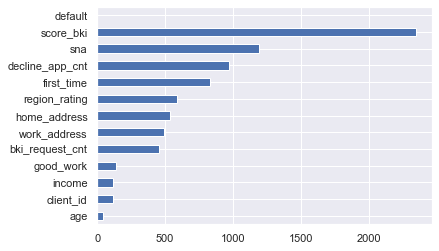

In [535]:
num_col = list(data.select_dtypes(include=['int64', 'float64']).columns)
imp_num = pd.Series(f_classif(train[num_col], train['default'])[0], index = num_col)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [604]:
test_roc([], test_name='start')

results                                            vectors
start  0.596664  [decline_app_cnt, age, first_time, home_addres...

In [99]:
results['start'][0]

0.5966635382151818

**Вывод.**
Целевая переменная не сбаллансирована. Хотя также нельзя сказать, что она разбалансирована. Теме не менее, отношение класса "0" к классу "1" составляет почти 7:1. Кроссвалидация не показывает состояния overfitting.

Стартовая "наивная" модель показала нам 60% точность.

vectors0
0          test
1  work_address

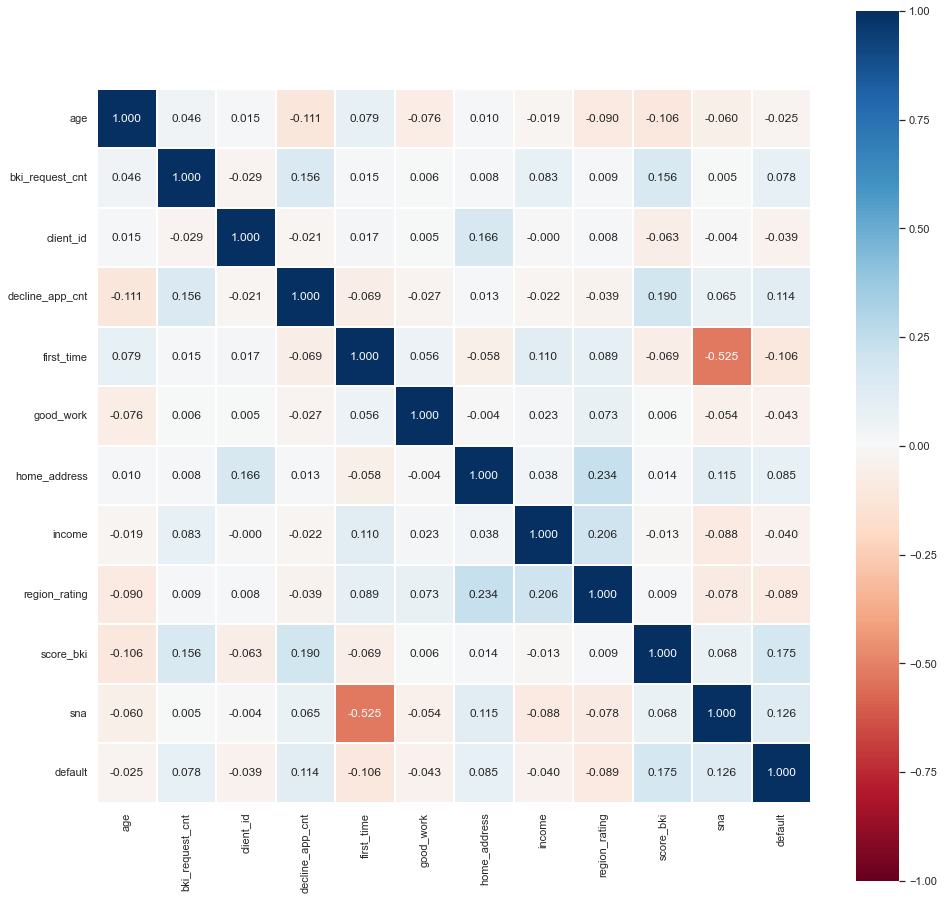

In [605]:
to_drop = ['test', 'work_address']
heatmap(to_drop)

In [606]:
test_roc(to_drop, test_name='start - work')

results                                            vectors
start         0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work  0.596752  [decline_app_cnt, age, first_time, home_addres...

Исключение взаимноскоррелированного вектора 'work_address' чуть-чуть улучшило результат. Это приводит к выводу, что нельзя стандартно подходить к трансформации векторов (просто применять стандартные методы без разбора), так как некоторые из них, даже трансформированные и стандартизированные - могут не улучшавть, а ухудшать модель.

<a id='2'></a>
# 2. Разведовательный анализ данных, очистка данных, трансформация данных для модели.
<a href='#0'> Содержание </a>

Я придерживаюсь своего метода работы с данными. Для меня данные - не числа, а смыслы. И для наилучшего их анализа нужно узнать скрытые за нимим значения. Причем, значения могут быть даже в пропусках данных. Таким образом, я проверяю каждый вектор, и разбираюсь с тем, почему он такой, как он может быть связан с целевым вектором, что вообще с ним можно сделать, а что - можно сделать совместно с другими векторами, то есть, как получить новые векторы.

<a id='21'></a>
## 2.1 Вектор **client_id**. Анализ распределения, дубликатов, связи с целевым признаком
<a href='#0'> Содержание </a>
Как ни странно это прозвучит, но очень часто в "ключах" скрыты возможные взаимосвязи с цельевым признаком, несмотря на то, что это просто "уникальные ключи клиетов". Смысл в том, что их назначают во времени, и целевая перменная развивается во времени: по этому, тут может быть связь!

In [ ]:
data.groupby('client_id')['client_id'].count().unique()
# array([1]
# коды клиентов не повторяются. ХОРОШО! А то бывали случаи...

In [ ]:
train.client_id.describe()

In [ ]:
test.client_id.describe()

Стандартное отклонение и среднее практически идентичны. Начальные и конечные значения также стоят рядом. Делаю вывод, что "тест" был выделен из общего датасета стандартным методом train_test_split с перемешиванием.

In [ ]:
lst = ['client_id','default']
train[lst].corr()
# обратная слабая корреляция. Но может быть тут можно еще что-то извлечь?

In [ ]:
x = train[(train.default == 1)]['client_id']
plt.hist(x, bins=1000)
plt.show()

Корреляция слабая, но на графике достаточно четко видена регрессия на снижение количества дефолтов с увеличением кода клиента. Возможно, если считать, что коды присваивались последовательно во времени, со временем, модель, предсказывающая дефолт работала лучше и должники допускали меньше дефолтов. а возможно, это просто состояние дел в экономике улучшилось, и кредиты лучше возвращают. В любом случае, попробую создать вектор с этой регрессией и попытаюсь использовать для предскзания.

Тут я добавлю еще важный момент. Так как статистических различий в трейне и тесте почти нет, то я буду модифицировать целый датасет (трейн+тест) и потом каждый раз выделять оттуда трейн. Трансформировать таблицы отдельно не вижу смысла.

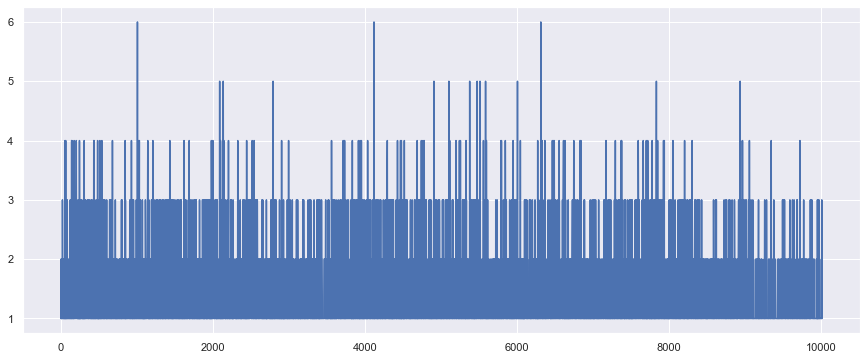

client_id      bins   def_100   default
client_id   1.000000  1.000000 -0.103838 -0.039242
bins        1.000000  1.000000 -0.103839 -0.039243
def_100    -0.103838 -0.103839  1.000000  0.358886
default    -0.039242 -0.039243  0.358886  1.000000

In [607]:
mb = 11                     # может быть

# делю код клиент "нацело" на размер корзины, группирую и создаю словарь
#data.insert(data.columns.get_loc('client_id')+1, 'bins', 0)
train['bins']=train.client_id.apply(lambda x: x//mb)
data['bins']=data.client_id.apply(lambda x: x//mb)
default_gr=train[train.default == 1].groupby('bins')['default'].sum()
default_dic=default_gr.to_dict()

# создаю новый вектор, добавляю туда сведения из словаря (по номеру "корзины" - статистика дефолтов)
# и делю на размер корзины
data['def_100'] = data.bins.map(default_dic)
data.def_100 = data.def_100/mb
data.def_100.fillna(0, inplace=True)
train = data[data.test ==0]


# иллюстрация дефолтов по "корзинам"
x = default_gr
plt.figure(figsize=(15, 6))
plt.plot(x)
plt.show()

# и корреляция
lst = ['client_id', 'bins', 'def_100','default']
train[lst].corr()

**Вау! Получился вектор с корреляцией 36%!**
Как я получил размер "корзины", показываю ниже:

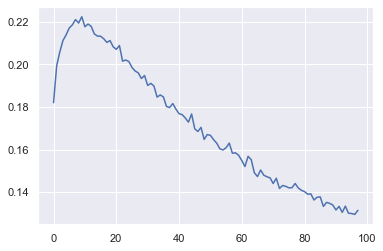

In [101]:
test_cor = dict()
df = train.copy()
for q in range(2, 100):
    df['bins'] = df.client_id.apply(lambda x: x//q)
    gr = df[df.default == 1].groupby('bins')['default'].sum().to_dict()
    df['def_100'] = df.bins.map(gr)
    df.def_100 = df.def_100/q
    cor = df[lst].corr()['def_100']['default']

    test_cor[q]=cor

#results
plt.plot(test_cor.values())
plt.show()

In [ ]:
val_max = max(test_cor.values())
test_corr_max = {k:v for k, v in test_cor.items() if v == val_max}
test_corr_max
# {11: 0.22238296427765722}

In [608]:
to_drop=['test', 'work_address', 'client_id', 'bins']

vectors0
0          bins
1     client_id
2          test
3  work_address

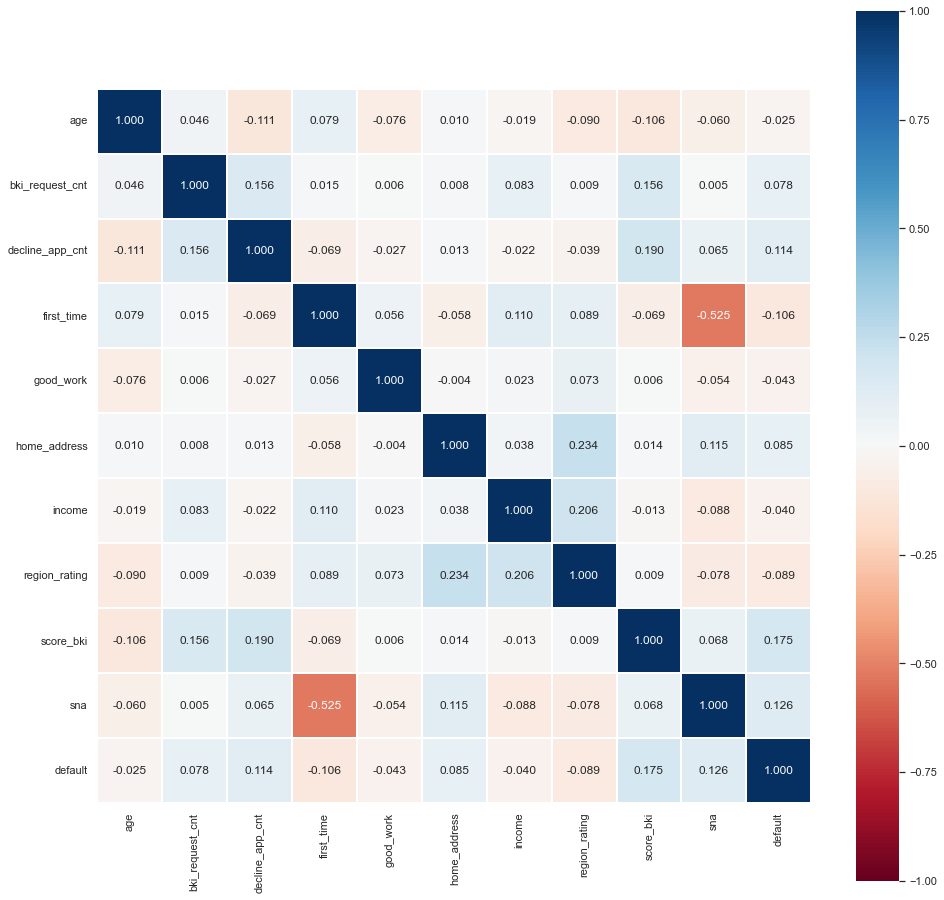

In [609]:
heatmap(to_drop)

In [610]:
test_roc(to_drop, test_name='2.1 def_100')

results                                            vectors
start         0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work  0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100   0.655999  [decline_app_cnt, age, first_time, home_addres...

<a id='22'></a>
## 2.2 Вектор **app_date**. Форматирование в подходящий формат, поиск связей даты с целевым признаком
<a href='#0'> Содержание </a>

In [611]:
data['app_date'] = pd.to_datetime(data["app_date"],errors="coerce")
train['app_date'] = pd.to_datetime(train["app_date"],errors="coerce")

In [612]:
data.app_date.min(), data.app_date.max()

#train.app_date.min(), train.app_date.max()
# (Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

Данные в векторе свидетельствуют, что весь датасет - это сведения о заявках за **первые четыре месяца 2014 года**.

In [613]:
data['app_weekday'] = data.app_date.dt.dayofweek
#data['app_month'] = data.app_date.dt.month
data['app_yearweek'] = data.app_date.dt.isocalendar().week
data['app_yearday'] = data.app_date.dt.dayofyear
train = data[data.test ==0]

In [614]:
default_gr=train[train.default == 1].groupby('app_weekday')['default'].sum().to_dict()
all_gr=train.groupby('app_weekday')['default'].count().to_dict()
data['def_rate_weekday'] = data.app_weekday.apply(lambda q: default_gr[q]/all_gr[q])

default_gr=train[train.default == 1].groupby('app_yearday')['default'].sum().to_dict()
all_gr=train.groupby('app_yearday')['default'].count().to_dict()
data['def_rate_yearday'] = data.app_yearday.apply(lambda q: default_gr[q]/all_gr[q])
train = data[data.test ==0]

In [615]:
col = ['app_weekday', 'def_rate_weekday',  'app_yearweek', 'app_yearday',
       'def_rate_yearday', 'default']

train[col].corr()
#train.info()

app_weekday  def_rate_weekday  app_yearweek  app_yearday  \
app_weekday          1.000000          0.092247     -0.097887    -0.039217   
def_rate_weekday     0.092247          1.000000     -0.010441    -0.005034   
app_yearweek        -0.097887         -0.010441      1.000000     0.998271   
app_yearday         -0.039217         -0.005034      0.998271     1.000000   
def_rate_yearday     0.017093          0.185296     -0.627907    -0.629442   
default              0.001069          0.011590     -0.039276    -0.039372   

                  def_rate_yearday   default  
app_weekday               0.017093  0.001069  
def_rate_weekday          0.185296  0.011590  
app_yearweek             -0.627907 -0.039276  
app_yearday              -0.629442 -0.039372  
def_rate_yearday          1.000000  0.062551  
default                   0.062551  1.000000

Манипуляции с датой привели к выводу, оставить в EDA только векторы 'app_yearweek', 'app_yearday', у которых корреляция с целвым вектором хотя бы не ниже "кода клиента". Также я думаю оставить вектор 'app_weekday'. в надежде, что dummy операция может принести пользу, хотя сейчас корреляция совершенно никакая...
Хорошее улучшение корреляции происходит на относительной доле дефолтов по группировке по дню года 'def_rate_yearday', а также по круппировке по дню недели 'def_rate_weekday'. Хотя в последнем случае речь идет об улучшении только до 1%...

In [616]:
to_drop= ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek']

vectors0
0   app_yearday
1  app_yearweek
2          bins
3     client_id
4          test
5  work_address

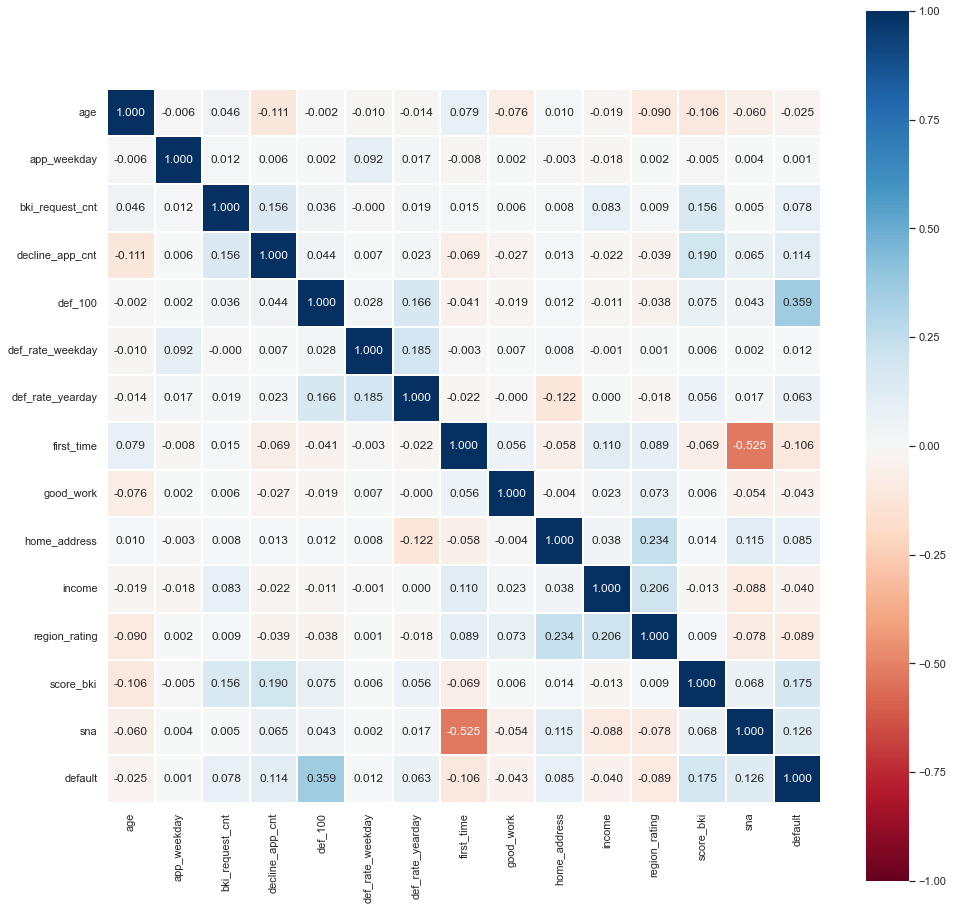

In [617]:
heatmap(to_drop, dd=train)

In [618]:
test_roc(to_drop, dd=train, test_name='2.2 dates')

results                                            vectors
start         0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work  0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100   0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates     0.657476  [decline_app_cnt, age, first_time, home_addres...

<a id='23'></a>
## 2.3 Вектор **education**. Заполнение пропусков. Конструирование смысла признака для целей связи с целевым признаком.
<a href='#0'> Содержание </a>

По определению - это вектор инофрмации об образовании заявителей.
В порядке возрастания уровня образованности:
1. **SCH**  -:-   57998 -:- Школа
2. **UGR**  -:-   14748 -:- Бакалавр
3. **GRD**  -:-   34768 -:- Магистр
4. **PGR**  -:-    1865 -:- Аспирант
5. **ACD**  -:-     291 -:- Доктор

Именно в таком порядке стоит нумеровать признак.

И еще. В этом векторе есть пропуски.

In [619]:
data.education.isna().sum()

478

Посмотрим на группировку заявителей по уровню образования. С начала в общем датасете...

In [ ]:
data.groupby('education')[['age', 'income', 'region_rating', 'sna', 'score_bki']].agg('mean')

In [ ]:
data[pd.isna(data.education)][['age', 'income', 'region_rating', 'sna', 'score_bki']].mean()

... и в тренировочной части - помострим статитсику дефолтов.

In [ ]:
train.groupby('education')['default'].agg('mean')

In [ ]:
train[pd.isna(train.education)]['default'].mean(), train[pd.isna(train.education)]['default'].sum()

Несмотря на большой соблазн заполнить пропуски самым частым значением (Школа), я исповедую более внимательное отношение к данным. Прежде всего, нужно учитывать, что это - анкеты в банк на получние кредита. Если кто проходил эту процедуру, то он знает, что утаивать что-то или врать в анкете - сильно рисковать получить отказ. Так что, я считаю, что этот вектор имеет пропуски потому что подходящего варианта заполнения (одно из пяти) не достаточно было, чтобы точно указать свое образование.

Далее, анализ показывает, что эта группа имеет средний доход существенно выше "SCH" и "UGR", хотя и не дотягивает до "GRD". Такая же картина и в дргих количественных признаках. А также, что еще более существенно, в тренирововчной части видно, что доля дефолтов не соответствует ни "SCH",  ни "UGR", тоже немного не дотягивая до "GRD".

Я делаю предположение, что эти люди имеют существенно лучшее образование, чем "Школа", но похвастаться другой стеенью они не могут - у них не законченное высшее образование. Таким образом, **я заполню пропуски "GRD"**, хоть это и не совсем точно в реальности, но, зато точнее для целевой переменной.

In [620]:
# линейная ординарность
edu1 = {'ACD': 1,
       'PGR': 4/5,
       'GRD': 3/5,
       'UGR': 2/5,
       'SCH': 1/5,
      }
edu1

{'ACD': 1, 'PGR': 0.8, 'GRD': 0.6, 'UGR': 0.4, 'SCH': 0.2}

In [621]:
# запомними, где были пропуски
data['edu_nan'] = data.education.apply(lambda q: 1 if pd.isna(q) else 0)
# заполним пропуски "высшим образованием (Магистр)"
data.education.fillna('GRD', inplace=True)
# создадим числовой ординарный вектор
data['edu']=data.education.map(edu1)
train=data[data.test==0]

In [622]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek', 'edu_nan']

vectors0
0   app_yearday
1  app_yearweek
2          bins
3     client_id
4       edu_nan
5          test
6  work_address

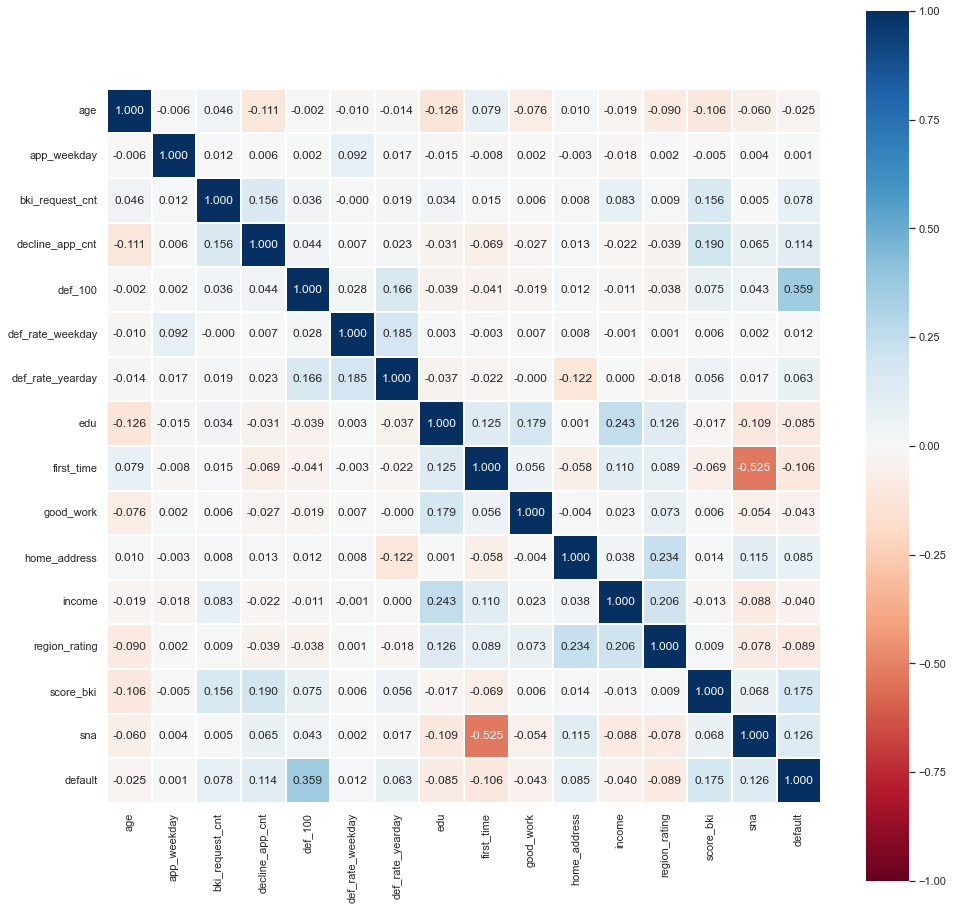

In [558]:
heatmap(to_drop, dd=train)

In [623]:
test_roc(to_drop, dd=train, test_name='2.3 edu')

results                                            vectors
start         0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work  0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100   0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates     0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu       0.657822  [decline_app_cnt, age, home_address, bki_reque...

<a id='24'></a>
## 2.4 Вектор **sex**. Преобразование в бинарный вектор (male vc female)
<a href='#0'> Содержание </a>

In [624]:
vector = 'sex'

sex  default_rate
F  61836      0.121241
M  48312      0.134411

Список значений: ['M' 'F']
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


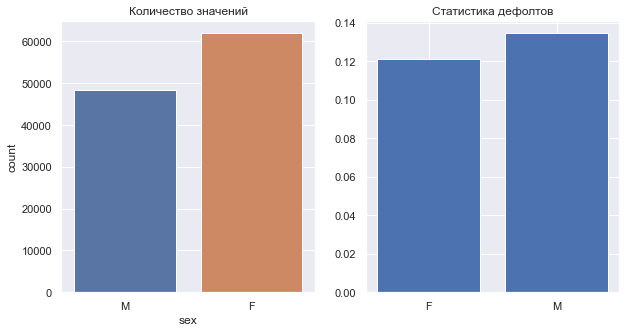

In [625]:
obj_stat(vector)

In [626]:
data['male']=data.sex.apply(lambda q: 1 if q=='M' else 0)
train=data[data.test==0]

vectors0
0   app_yearday
1  app_yearweek
2          bins
3     client_id
4       edu_nan
5          test
6  work_address

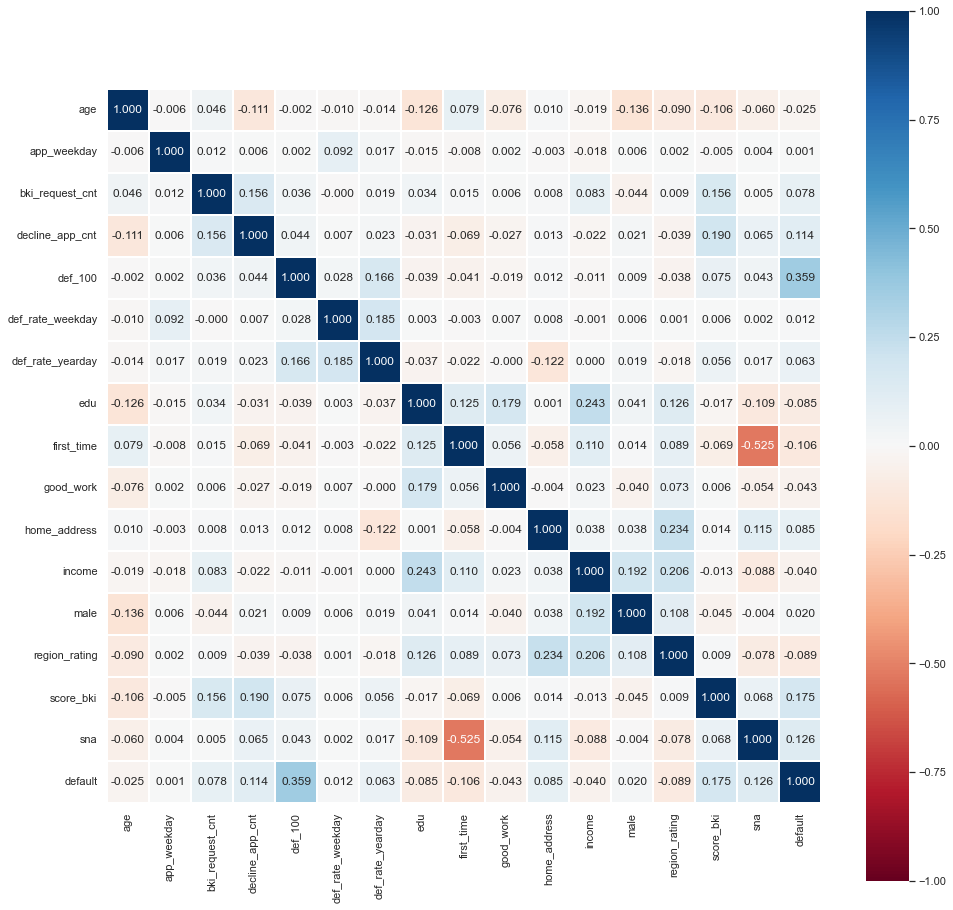

In [627]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek', 'edu_nan']
heatmap(to_drop, dd=train)

In [628]:
test_roc(to_drop, dd=train, test_name='2.4 male')

results                                            vectors
start         0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work  0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100   0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates     0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu       0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male      0.658109  [decline_app_cnt, age, home_address, bki_reque...

Не имело значения, мжчину или женщину считать за 1. Хотя женщин в датасете больше.

<a id='213'></a>
## 2.13 Вектор **age**.
<a href='#0'> Содержание </a>

In [629]:
vector='age'

<AxesSubplot:xlabel='age', ylabel='Count'>

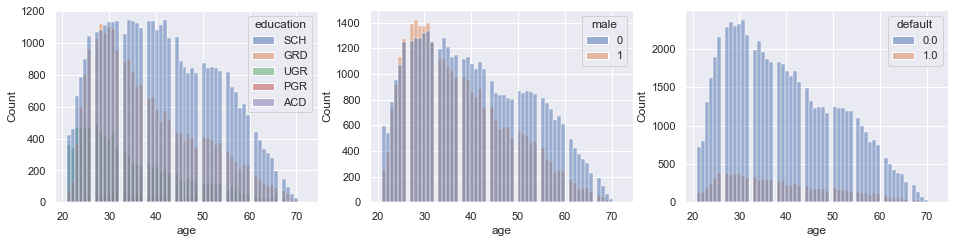

In [630]:
plt.figure(figsize=(16, 12))

plt.subplot(331)
sns.histplot(data=train, x='age', kde=False, hue='education')

plt.subplot(332)
sns.histplot(data=train, x='age', kde=False, hue='male')

plt.subplot(333)
sns.histplot(data=train, x='age', kde=False, hue='default')

In [631]:
data['def_age'] = data.age.map(def_rate_count(vector))
train=data[data.test==0]

In [632]:
scaler = StandardScaler()
qq = data.age.values.reshape(data.age.values.shape[0],1)
data['age_std'] = scaler.fit_transform(qq)
train=data[data.test == 0]

vectors0      vectors1
0       age_std  work_address
1   app_yearday              
2  app_yearweek              
3          bins              
4     client_id              
5       edu_nan              
6          test

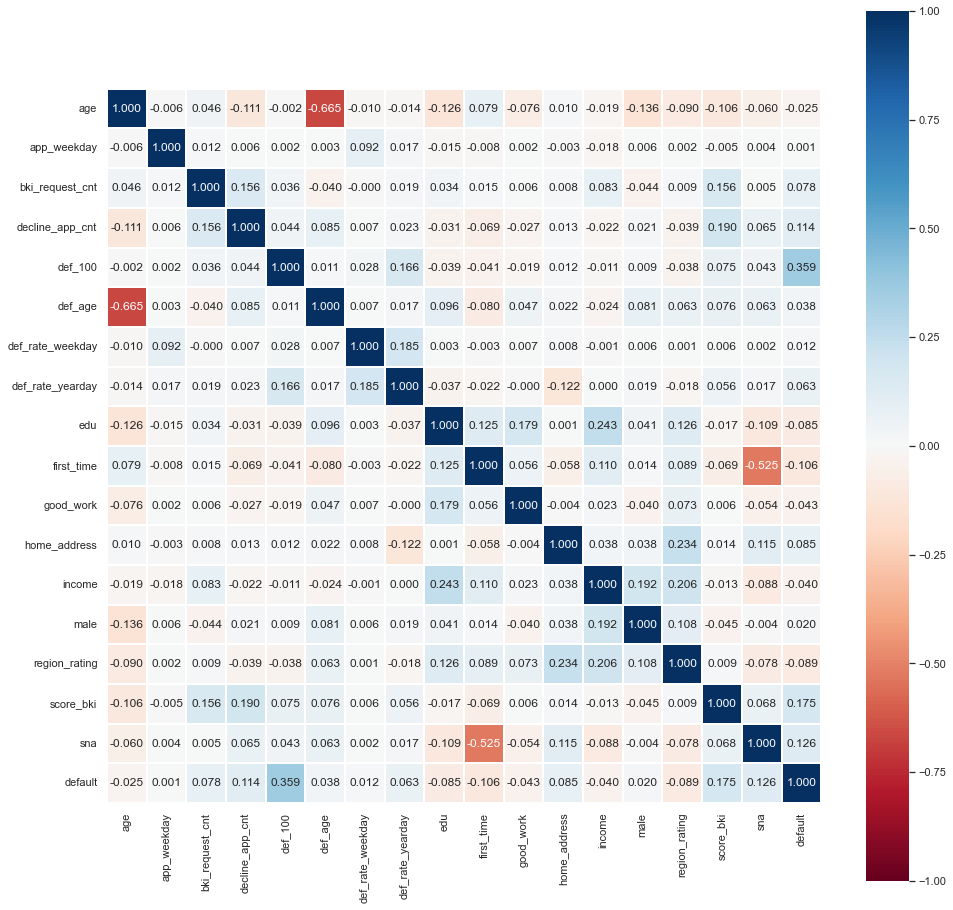

In [633]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'age_std']
heatmap(to_drop, dd=train)

In [635]:
test_roc(to_drop, dd=train, test_name='2.6 age')

results                                            vectors
start         0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work  0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100   0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates     0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu       0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male      0.658109  [decline_app_cnt, age, home_address, bki_reque...
2.6 age       0.687019  [decline_app_cnt, age, home_address, bki_reque...

Вектор 'age' лучше не стандартизацизировать - это ухудшает модель

<a id='25'></a>
## 2.5 Векторы **car** и **car_type**. Преобразование в бинарный вектор.
<a href='#0'> Содержание </a>

In [636]:
vector1, vector2 = 'car', 'car_type'

car  default_rate
N  74290      0.136960
Y  35858      0.106271

Список значений: ['Y' 'N']
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


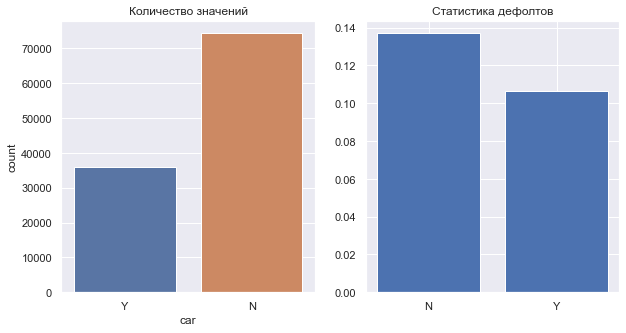

In [639]:
obj_stat(vector1)

In [640]:
data.car=data.car.apply(lambda q: 1 if q=="Y" else 0)
data.car_type=data.car_type.apply(lambda q: 1 if q=="Y" else 0)
train=data[data.test == 0]

In [649]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'age_std', 'car', 'car_type']

In [ ]:
heatmap(to_drop, dd=train)

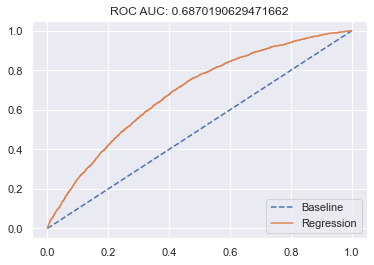

vectors0          vectors1       vectors2
0               age  def_rate_yearday  region_rating
1       app_weekday               edu      score_bki
2   bki_request_cnt        first_time            sna
3   decline_app_cnt         good_work               
4           def_100      home_address               
5           def_age            income               
6  def_rate_weekday              male

In [650]:
test_roc(to_drop, dd=train)

In [651]:
test_roc(to_drop, dd=train, test_name='2.5 NO car')

results                                            vectors
start         0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work  0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100   0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates     0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu       0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male      0.658109  [decline_app_cnt, age, home_address, bki_reque...
2.6 age       0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.5 NO car    0.687019  [decline_app_cnt, age, home_address, bki_reque...

Вектор 'car_type'  имеет слишком много кросс-корреляций с другими векторами, видимо по этому его пришлось удалить - модель показала существкенное ухудшение результата. Это не смотря на то, что корреляция с целевым  вектором заметно лучше вектора 'car'. Но для "типа машины" у нас есть другие планы.

<a id='26'></a>
## 2.6 Векторы **decline_app_cnt**, **first_time** и **bki_request_cnt** . Конструирование смысла признака для целей связи с целевым признаком. Интегрирование новых признаков.
<a href='#0'> Содержание </a>

In [655]:
vector1, vector2 = 'decline_app_cnt', 'first_time'

In [652]:
train[['decline_app_cnt', 'first_time', 'default']].corr()

decline_app_cnt  first_time   default
decline_app_cnt         1.000000   -0.069099  0.113682
first_time             -0.069099    1.000000 -0.105579
default                 0.113682   -0.105579  1.000000

In [653]:
dd = train.groupby(['decline_app_cnt'])[['decline_app_cnt', 'default']].agg({'decline_app_cnt': 'count', 'default': 'sum'})
dd['d100'] = dd.default / dd.decline_app_cnt
dd

decline_app_cnt  default      d100
decline_app_cnt                                    
0                          61214   6705.0  0.109534
1                           8397   1577.0  0.187805
2                           2468    601.0  0.243517
3                            903    247.0  0.273533
4                            414    120.0  0.289855
5                            165     43.0  0.260606
6                            113     34.0  0.300885
7                             48     14.0  0.291667
8                             19     10.0  0.526316
9                             24      9.0  0.375000
10                            11      5.0  0.454545
11                             9      3.0  0.333333
12                             2      0.0  0.000000
13                             3      0.0  0.000000
14                             2      1.0  0.500000
15                             1      1.0  1.000000
16                             2      0.0  0.000000
19                             1      1.0  1.000000
22                             1      1.0  1.000000
24                             1      0.0  0.000000
33                             1      0.0  0.000000

Корреляция с целевым вектором очень высока - третье место в списке. Конечно, есть в списке настойчивые парни с >30 отказов в выдаче кредита, но фактически уже после 8 попыток много желающих нет. Так что, все случаи после 8 - сложим в одну корзину "8".

In [664]:
# создадим новый вектор с количеством отказов от 1 до 8 (включительно все что больше в 8)
data['decline']=train.decline_app_cnt.apply(lambda q: 8 if q>=8 else q)
train=data[data.test == 0]
vector='decline'

In [669]:
data['def_decline']=train.decline.map(def_rate_count(vector))
train = data[data.test == 0]

In [670]:
train[['decline_app_cnt', 'decline', 'def_decline', 'default']].corr()

decline_app_cnt   decline  def_decline   default
decline_app_cnt         1.000000  0.982581     0.917478  0.113682
decline                 0.982581  1.000000     0.943579  0.117609
def_decline             0.917478  0.943579     1.000000  0.124641
default                 0.113682  0.117609     0.124641  1.000000

In [671]:
data['decline_frq'] = np.log(data.decline_app_cnt)/np.log(data.first_time)
train = data[data.test == 0]

In [672]:
train[['decline_app_cnt', 'decline', 'def_decline', 'decline_frq', 'default']].corr()

decline_app_cnt   decline  def_decline  decline_frq   default
decline_app_cnt         1.000000  0.982581     0.917478     0.886336  0.113682
decline                 0.982581  1.000000     0.943579     0.918282  0.117609
def_decline             0.917478  0.943579     1.000000     0.933308  0.124641
decline_frq             0.886336  0.918282     0.933308     1.000000  0.096045
default                 0.113682  0.117609     0.124641     0.096045  1.000000

In [675]:
vector = 'decline_frq'
dd = def_rate_count(vector)

{-inf: 0.1095337667853759,
 0.0: 0.17336868463691266,
 0.5: 0.2009132420091324,
 0.6309297535714574: 0.2025440313111546,
 0.7924812503605781: 0.2571428571428571,
 1.0: 0.27155172413793105,
 1.160964047443681: 0.10714285714285714,
 1.2618595071429148: 0.2529411764705882,
 1.292481250360578: 0.29411764705882354,
 1.403677461028802: 0.5,
 1.4649735207179269: 0.21875,
 1.5: 0.75,
 1.5849625007211563: 0.25925925925925924,
 1.6309297535714573: 0.2916666666666667,
 1.6609640474436813: 0.0,
 1.7297158093186489: 1.0,
 1.7712437491614221: 0.25,
 1.892789260714372: 0.4444444444444444,
 1.9036774610288019: 1.0,
 2.0: 0.3333333333333333,
 2.095903274289385: 0.6666666666666666,
 2.182658338644138: 0.3333333333333333,
 2.321928094887362: 0.4,
 2.3347175194727927: 0.0,
 2.464973520717927: 1.0,
 2.5237190142858297: 0.0,
 2.584962500721156: 0.2916666666666667,
 2.680143859246375: 1.0,
 2.807354922057604: 0.29411764705882354,
 2.8927892607143724: 0.0,
 3.0: 0.6666666666666666,
 3.1699250014423126: 0.0,
 

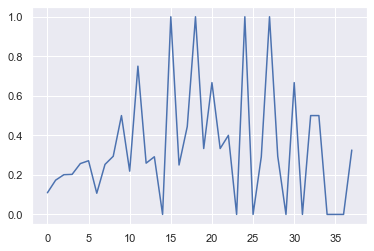

In [676]:
plt.plot(dd.values())
plt.show()

In [677]:
data['def_dec_frq']=data.decline_frq.map(dd)
train = data[data.test == 0]

In [678]:
data.decline_frq.fillna(0, inplace=True)
data.def_dec_frq.fillna(0, inplace=True)
train=data[data.test == 0]

In [679]:
train[['decline_app_cnt', 'decline', 'def_decline', 'decline_frq','def_dec_frq', 'default']].corr()

decline_app_cnt   decline  def_decline  decline_frq  \
decline_app_cnt         1.000000  0.982581     0.917478     0.890100   
decline                 0.982581  1.000000     0.943579     0.921348   
def_decline             0.917478  0.943579     1.000000     0.936508   
decline_frq             0.890100  0.921348     0.936508     1.000000   
def_dec_frq             0.736503  0.758805     0.748186     0.609428   
default                 0.113682  0.117609     0.124641     0.076163   

                 def_dec_frq   default  
decline_app_cnt     0.736503  0.113682  
decline             0.758805  0.117609  
def_decline         0.748186  0.124641  
decline_frq         0.609428  0.076163  
def_dec_frq         1.000000  0.090542  
default             0.090542  1.000000

In [694]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'age_std', 'car', 'car_type',
           'decline', 'def_dec_frq', 'decline_frq', 'def_decline' ]

In [ ]:
heatmap(to_drop, dd=train)

In [696]:
test_roc(to_drop, dd=train, test_name='2.6 no decline')

results                                            vectors
start           0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work    0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100     0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates       0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu         0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male        0.658109  [decline_app_cnt, age, home_address, bki_reque...
2.6 age         0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.5 NO car      0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.6 no decline  0.687019  [decline_app_cnt, age, home_address, bki_reque...

Теперь проверим статистику запросов к БКИ - запросов на кредиты. И посчитаем "частоту" запросов кредитов через вектор 'first_time', и статистику дефолтов по частоте кредитов.

In [697]:
vector = 'bki_request_cnt'
data.bki_request_cnt.value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
27        5
28        5
25        5
32        4
26        4
29        3
33        2
40        2
45        1
53        1
41        1
34        1
46        1
47        1
36        1
Name: bki_request_cnt, dtype: int64

In [699]:
# вектор частоты обращений за кредитами (логарифмируем для пере-масштабирования)
data['credit_frq']= np.log(data.bki_request_cnt)/np.log(data.first_time)
data.credit_frq.fillna(0, inplace=True)
train = data[data.test ==0 ]
vector = 'credit_frq'

In [701]:
# создадим новый вектор и подставим статистику дефолтов по частоте кредитов, преобразованную в словарь
data['def_credit_frq']=data.credit_frq.map(def_rate_count(vector))
data.def_credit_frq.fillna(0, inplace=True)
train = data[data.test == 0]

In [702]:
train[['bki_request_cnt', 'credit_frq', 'def_credit_frq', 'default']].corr()

bki_request_cnt  credit_frq  def_credit_frq   default
bki_request_cnt         1.000000    0.832887        0.630977  0.078242
credit_frq              0.832887    1.000000        0.655765  0.061065
def_credit_frq          0.630977    0.655765        1.000000  0.116640
default                 0.078242    0.061065        0.116640  1.000000

In [715]:
data.credit_frq = data.credit_frq.apply(lambda q: 0 if q < 0 else 6 if q > 6 else q)
train = data[data.test == 0]

In [732]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'age_std', 'car', 'car_type',
           'decline', 'def_dec_frq', 'decline_frq', 'def_decline',
           'credit_frq']

In [ ]:
heatmap(to_drop, dd=train)

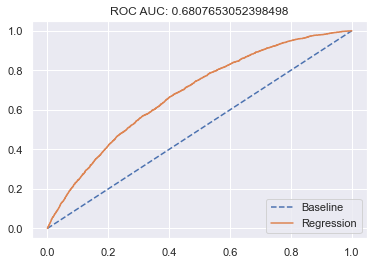

vectors0          vectors1       vectors2
0              age  def_rate_weekday           male
1      app_weekday  def_rate_yearday  region_rating
2  bki_request_cnt               edu      score_bki
3  decline_app_cnt        first_time            sna
4          def_100         good_work               
5          def_age      home_address               
6   def_credit_frq            income

In [733]:
test_roc(to_drop, dd=train)

first_time  default_rate
1       18296      0.186126
2       17247      0.155429
3       46588      0.120269
4       28017      0.082030

Список значений: [1 4 3 2]
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


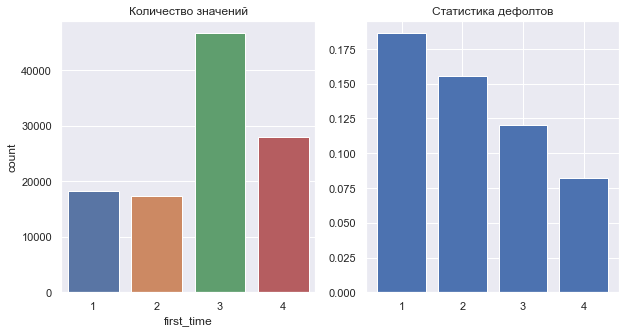

In [734]:
vector = 'first_time'
obj_stat(vector)

In [735]:
vector = 'first_time'
data['def_history']=data.first_time.map(def_rate_count(vector))
train=data[data.test == 0]

In [736]:
train[['first_time', 'def_history', 'default']].corr()

first_time  def_history   default
first_time     1.000000    -0.998676 -0.105579
def_history   -0.998676     1.000000  0.105719
default       -0.105579     0.105719  1.000000

In [749]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'def_age', 'age_std', 'car_type',
           'decline_frq', 'decline', 'def_dec_frq',
           'bki_request_cnt', 'credit_frq',
           'def_history']

In [ ]:
heatmap(to_drop, dd=train)

In [751]:
test_roc(to_drop, dd=train, test_name='-defage +car')

results                                            vectors
start           0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work    0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100     0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates       0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu         0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male        0.658109  [decline_app_cnt, age, home_address, bki_reque...
2.6 age         0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.5 NO car      0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.6 no decline  0.687019  [decline_app_cnt, age, home_address, bki_reque...
-defage +car    0.727320  [decline_app_cnt, age, home_address, def_decli...

Статситика дефолтов по длительности крелдитной истории не улучшила никак модель.

<a id='27'></a>
## 2.7 Векторы **score_bki**. Самый лучший вектор!
<a href='#0'> Содержание </a>


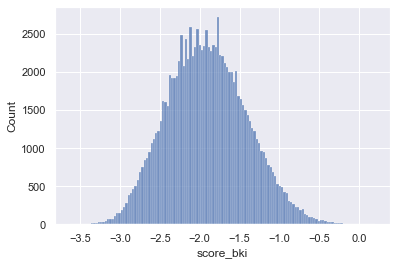

In [752]:
sns.histplot(data=data.score_bki)
plt.show()

In [414]:
scaler = StandardScaler()
qq = data.score_bki.values.reshape(data.score_bki.values.shape[0],1)
data['score_bki_std'] = scaler.fit_transform(qq)
train=data[data.test == 0]

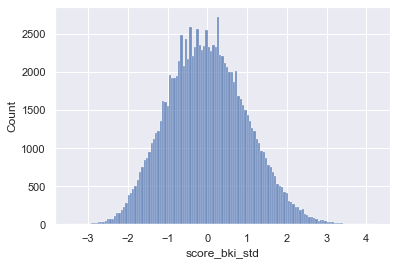

In [415]:
sns.histplot(data=data.score_bki_std)
plt.show()

In [416]:
train[['score_bki', 'score_bki_std', 'default']].corr()

score_bki  score_bki_std   default
score_bki       1.000000       1.000000  0.175369
score_bki_std   1.000000       1.000000  0.175369
default         0.175369       0.175369  1.000000

In [420]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'def_age', 'age_std', 'car_type',
           'decline_frq', 'decline', 'def_dec_frq',
           'bki_request_cnt', 'credit_frq',
           'def_history', 'score_bki_std']

In [ ]:
heatmap(to_drop, dd=train)

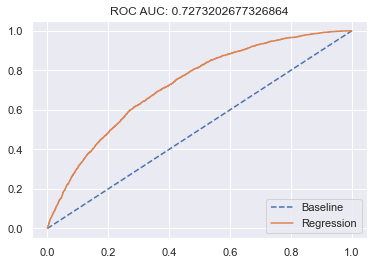

vectors0          vectors1       vectors2
0              age  def_rate_weekday           male
1      app_weekday  def_rate_yearday  region_rating
2              car               edu      score_bki
3  decline_app_cnt        first_time            sna
4          def_100         good_work               
5   def_credit_frq      home_address               
6      def_decline            income

In [421]:
test_roc(to_drop, dd=train)

Стандартизация вектора ухудшает модель. Не будем его использовать!

<a id='28'></a>
## 2.8 Векторы **home_address** и **work_address**. Конструирование смысла признака для целей связи с целевым признаком.
<a href='#0'> Содержание </a>


In [753]:
vector1, vector2 ='home_address', 'work_address'

home_address  default_rate
1         48688      0.092896
2         59591      0.155146
3          1869      0.116057

Список значений: [1 2 3]
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


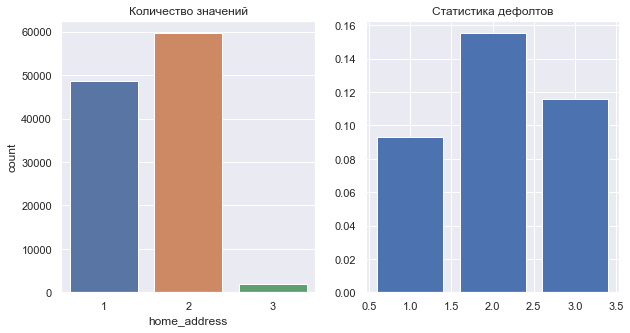

In [754]:
obj_stat(vector1, dd=data)

work_address  default_rate
1         12274      0.074154
2         30761      0.102507
3         67113      0.147957

Список значений: [2 3 1]
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


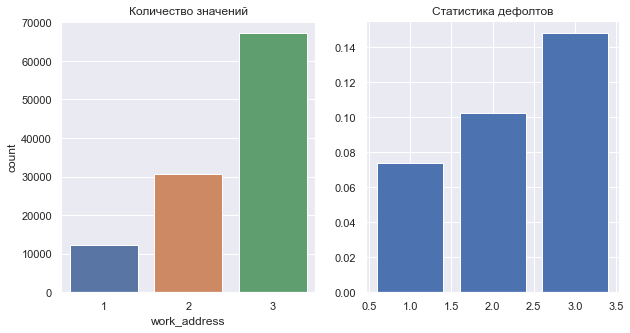

In [755]:
obj_stat(vector2, dd=data)

In [424]:
train[['home_address', 'work_address', 'income', 'region_rating', 'default']].corr()

home_address  work_address    income  region_rating   default
home_address       1.000000      0.728139  0.038343       0.233820  0.084637
work_address       0.728139      1.000000  0.049721       0.253541  0.081582
income             0.038343      0.049721  1.000000       0.205674 -0.039752
region_rating      0.233820      0.253541  0.205674       1.000000 -0.089035
default            0.084637      0.081582 -0.039752      -0.089035  1.000000

Понять кодировку адресов трудно. Попытка связать домашний адрес с рейтингом района, а рабочий - с доходом, не дала ничего - корреляция низкая, да еще и почти не отличающаяся.
Сделаем векторы статистики дефолтов по адресам и интегральный вектор статистики дефолтов по двум векторам адресов

In [756]:
dd1 = def_rate_count(vector1)
dd2 = def_rate_count(vector2)
data['def_address_home']= data.home_address.map(dd1)
data['def_address_work'] = data.work_address.map(dd2)
data['def_address'] = data.def_address_home + data.def_address_work
train = data[data.test ==0]

In [757]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
          'edu_nan', 'def_age', 'age_std', 'car_type',
          'decline_frq', 'decline', 'def_dec_frq',
          'bki_request_cnt', 'credit_frq',
          'def_history', 'score_bki_std',
          'def_address_home', 'def_address_work']

vectors0          vectors1       vectors2
0          age_std        credit_frq    def_history
1      app_yearday           decline        edu_nan
2     app_yearweek       decline_frq  score_bki_std
3             bins  def_address_home           test
4  bki_request_cnt  def_address_work   work_address
5         car_type           def_age               
6        client_id       def_dec_frq

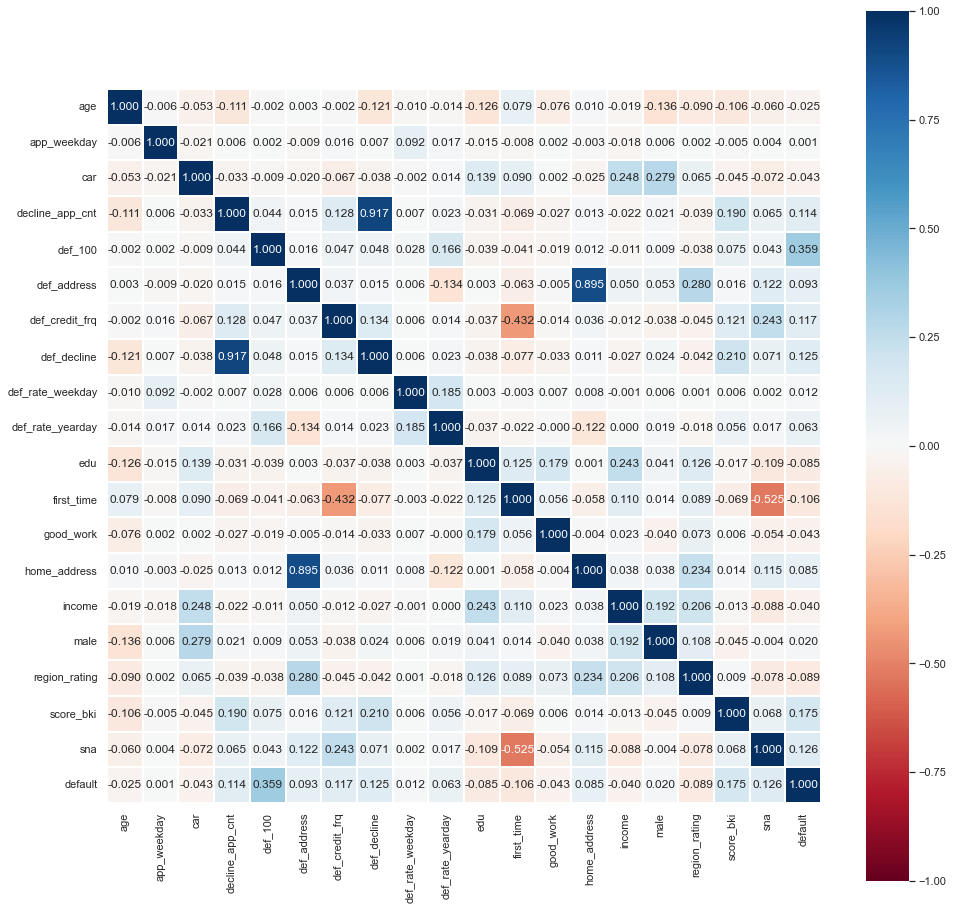

In [758]:
heatmap(to_drop, dd=train)

In [760]:
test_roc(to_drop, dd=train, test_name='2.8 address')

results                                            vectors
start           0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work    0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100     0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates       0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu         0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male        0.658109  [decline_app_cnt, age, home_address, bki_reque...
2.6 age         0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.5 NO car      0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.6 no decline  0.687019  [decline_app_cnt, age, home_address, bki_reque...
-defage +car    0.727320  [decline_app_cnt, age, home_address, def_decli...
2.8 address     0.728020  [decline_app_cnt, age, home_address, def_decli...

<a id='210'></a>
## 2.10 Векторы **foreign_passport** и **good_work**. Преобразование в бинарный вектор.
<a href='#0'> Содержание </a>


In [761]:
vector1, vector2 ='foreign_passport', 'good_work'

good_work  default_rate
0      91917      0.133409
1      18231      0.094502

Список значений: [0 1]
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


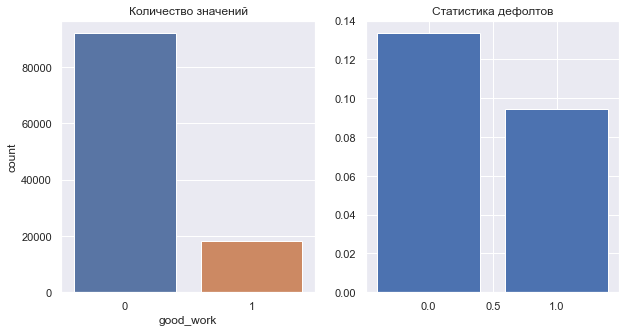

In [764]:
obj_stat(vector2, dd=data)

In [765]:
data.foreign_passport=data.foreign_passport.apply(lambda q: 1 if q=="Y" else 0)
train=data[data.test == 0]

In [777]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'def_age', 'age_std', 'car_type',
           'decline_frq', 'decline', 'def_dec_frq',
           'bki_request_cnt', 'credit_frq',
           'def_history', 'score_bki_std',
           'def_address_home', 'def_address_work', 'foreign_passport']

vectors0          vectors1       vectors2
0          age_std        credit_frq    def_history
1      app_yearday           decline        edu_nan
2     app_yearweek       decline_frq  score_bki_std
3             bins  def_address_home           test
4  bki_request_cnt  def_address_work   work_address
5         car_type           def_age               
6        client_id       def_dec_frq

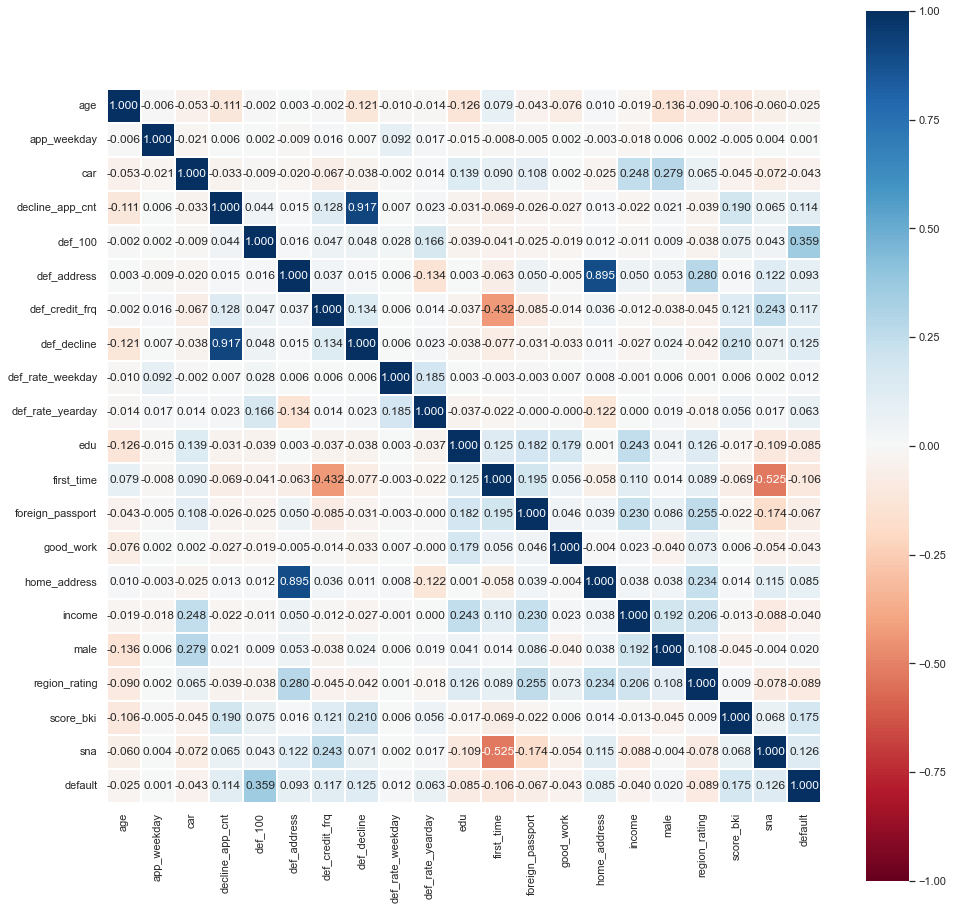

In [767]:
heatmap(to_drop, dd=train)

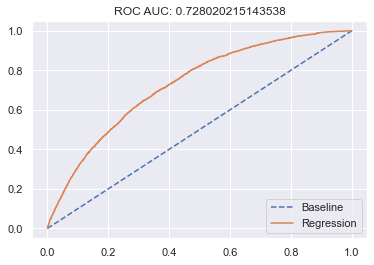

vectors0          vectors1       vectors2
0              age       def_decline         income
1      app_weekday  def_rate_weekday           male
2              car  def_rate_yearday  region_rating
3  decline_app_cnt               edu      score_bki
4          def_100        first_time            sna
5      def_address         good_work               
6   def_credit_frq      home_address

In [778]:
test_roc(to_drop, dd=train)

Не очень то и надо! Вектор "Загранпаспорт" ухудшал модель. Ну, у меня не него другие планы.

<a id='29'></a>
## 2.9 Вектор **region_rating**.
<a href='#0'> Содержание </a>

region_rating  default_rate
20            313      0.213592
30            434      0.190000
40          17947      0.169702
50          40981      0.136141
60          23999      0.128834
70           9304      0.092434
80          17170      0.073154

Список значений: [50 80 60 40 70 20 30]
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


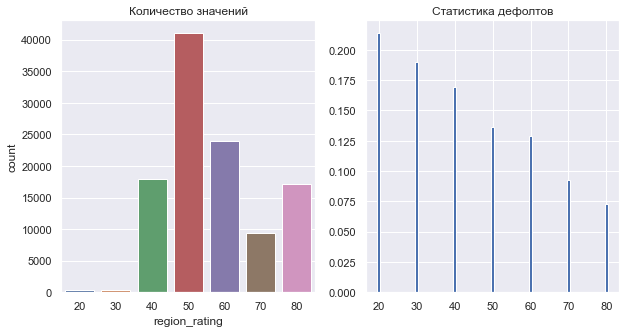

In [780]:
vector = 'region_rating'
obj_stat(vector)

In [781]:
data['def_region'] = data.region_rating.map(def_rate_count(vector))
train = data[data.test == 0]

In [786]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'def_age', 'age_std', 'car_type',
           'decline_frq', 'decline', 'def_dec_frq',
           'bki_request_cnt', 'credit_frq',
           'def_history', 'score_bki_std',
           'def_address_home', 'def_address_work', 'foreign_passport', 'def_region']


vectors0          vectors1          vectors2
0          age_std        credit_frq       def_history
1      app_yearday           decline           edu_nan
2     app_yearweek       decline_frq  foreign_passport
3             bins  def_address_home     score_bki_std
4  bki_request_cnt  def_address_work              test
5         car_type           def_age      work_address
6        client_id       def_dec_frq

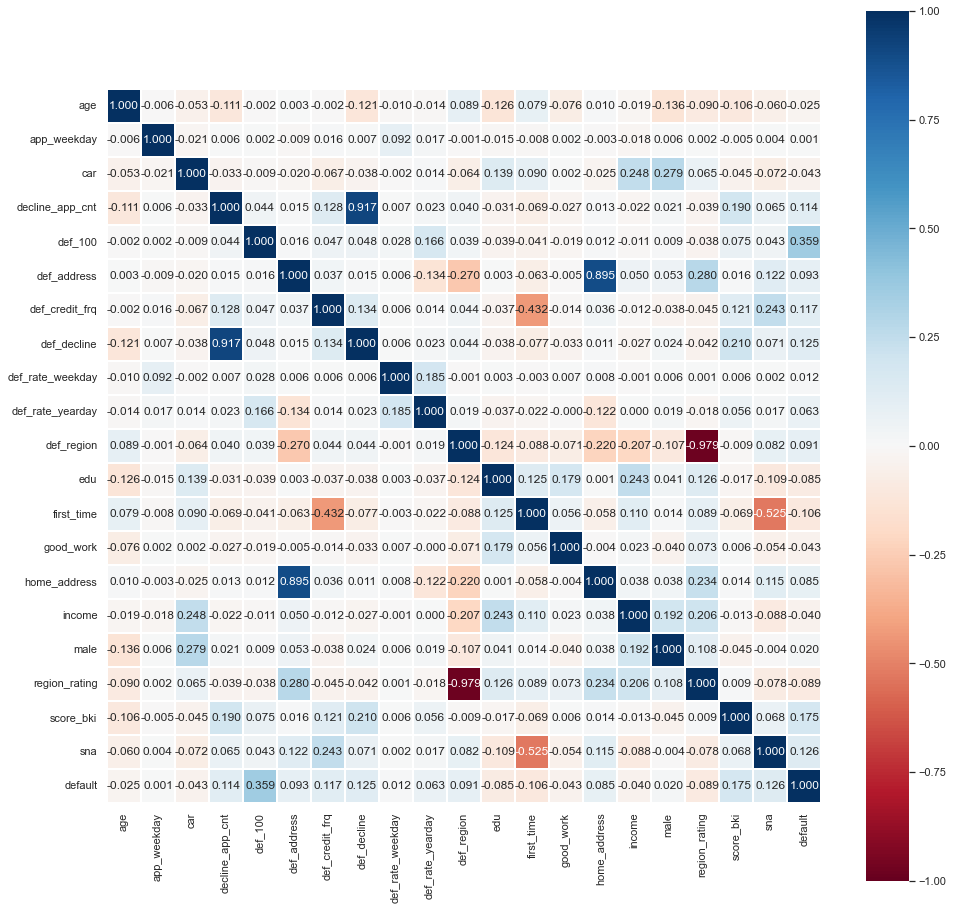

In [782]:
heatmap(to_drop, dd=train)

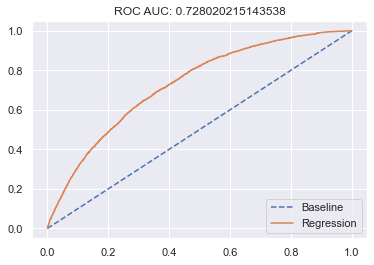

vectors0          vectors1       vectors2
0              age       def_decline         income
1      app_weekday  def_rate_weekday           male
2              car  def_rate_yearday  region_rating
3  decline_app_cnt               edu      score_bki
4          def_100        first_time            sna
5      def_address         good_work               
6   def_credit_frq      home_address

In [787]:
test_roc(to_drop, dd=train)

<a id='211'></a>
## 2.11 Вектор **income**.
<a href='#0'> Содержание </a>

In [789]:
vector = 'income'
train[[vector, target]].corr()

income   default
income   1.000000 -0.039752
default -0.039752  1.000000

<AxesSubplot:xlabel='income', ylabel='count'>

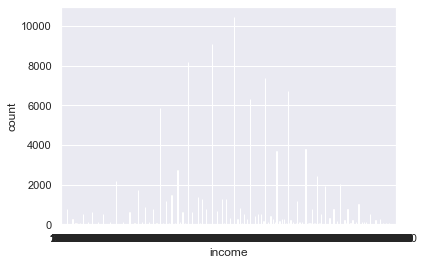

In [790]:
sns.countplot(data.income)

In [791]:
scaler = StandardScaler()
qq = data.income.values.reshape(data.income.values.shape[0],1)
data['income_std'] = scaler.fit_transform(qq)
train = data[data.test == 0]

In [793]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'def_age', 'age_std', 'car_type',
           'decline_frq', 'decline', 'def_dec_frq',
           'bki_request_cnt', 'credit_frq',
           'def_history', 'score_bki_std',
           'def_address_home', 'def_address_work', 'foreign_passport',
           'def_region', 'income']


vectors0          vectors1          vectors2
0          age_std        credit_frq       def_history
1      app_yearday           decline        def_region
2     app_yearweek       decline_frq           edu_nan
3             bins  def_address_home  foreign_passport
4  bki_request_cnt  def_address_work     score_bki_std
5         car_type           def_age              test
6        client_id       def_dec_frq      work_address

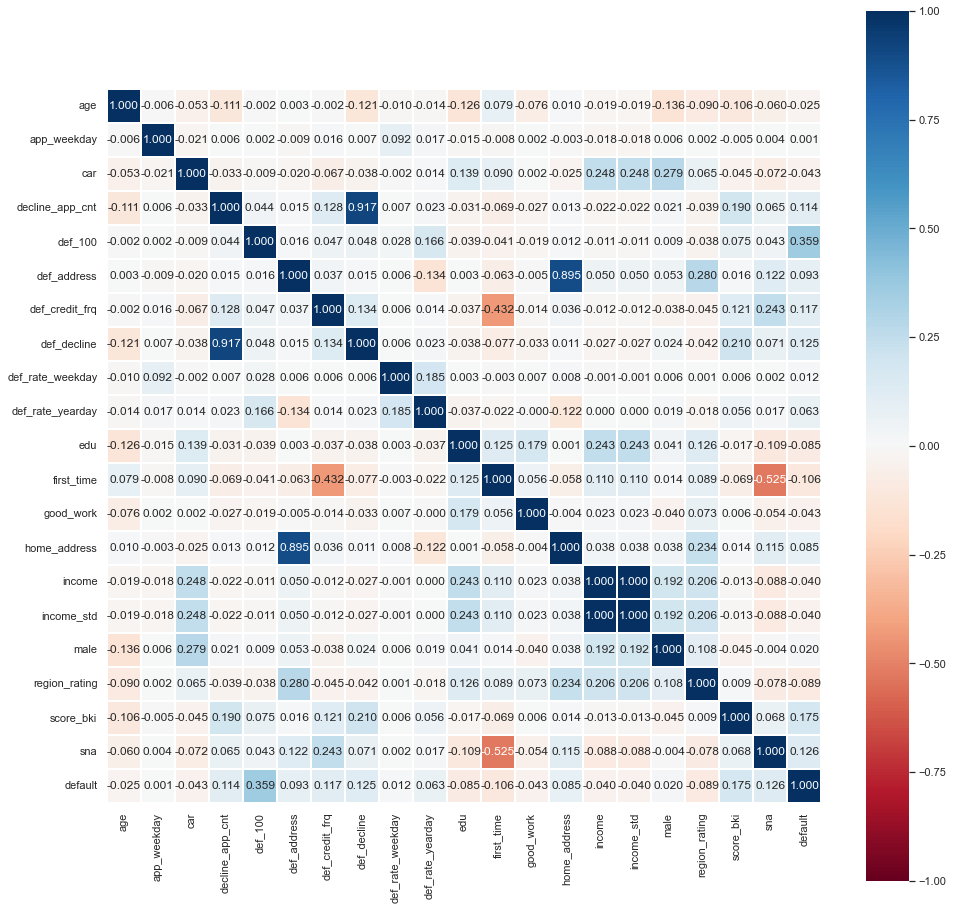

In [792]:
heatmap(to_drop, dd=train)

In [795]:
test_roc(to_drop, dd=train, test_name='2.11 income')

results                                            vectors
start           0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work    0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100     0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates       0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu         0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male        0.658109  [decline_app_cnt, age, home_address, bki_reque...
2.6 age         0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.5 NO car      0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.6 no decline  0.687019  [decline_app_cnt, age, home_address, bki_reque...
-defage +car    0.727320  [decline_app_cnt, age, home_address, def_decli...
2.8 address     0.728020  [decline_app_cnt, age, home_address, def_decli...
2.11 income     0.804547  [decline_app_cnt, age, home_address, def_decli...

А вот стандартизация вектора "доход" очень даже зарешала! 80,4% - это сила!

<a id='212'></a>
## 2.12 Вектор **sna**. Тоже не плох!
<a href='#0'> Содержание </a>

А теперь - коррупция!
Вектор 'sna' - это индикатор связи заемщика с сотрудниками банка. То есть  - аффилированные лица. Если не ошибаюсь, то 4 уровень - это самый близкий к руководству уровень. Но это не точно!

In [68]:
vector = 'sna'
train[[vector, target]].corr()

KeyError: "['sna'] not in index"

<AxesSubplot:xlabel='sna', ylabel='count'>

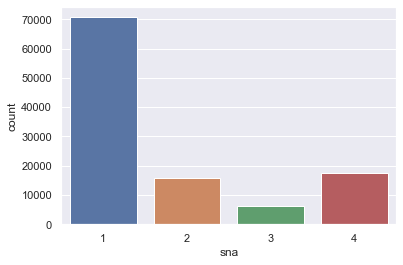

In [801]:
sns.countplot(data.loc[:,vector])

sna  default_rate
1  70681      0.098201
2  15832      0.149821
3   6154      0.157652
4  17481      0.211507

Список значений: [4 1 2 3]
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


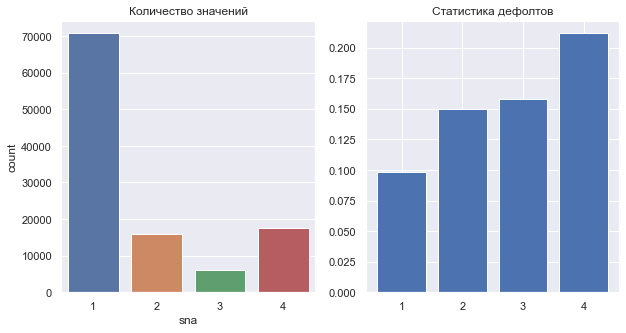

In [798]:
obj_stat(vector)

In [805]:
data['def_sna']=data.sna.map(def_rate_count(vector))
train = data[data.test == 0]

In [808]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'def_age', 'age_std', 'car_type',
           'decline_frq', 'decline', 'def_dec_frq',
           'bki_request_cnt', 'credit_frq',
           'def_history', 'score_bki_std',
           'def_address_home', 'def_address_work', 'foreign_passport',
           'def_region', 'income', 'sna']

vectors0          vectors1          vectors2      vectors3
0          age_std        credit_frq       def_history  work_address
1      app_yearday           decline        def_region              
2     app_yearweek       decline_frq           edu_nan              
3             bins  def_address_home  foreign_passport              
4  bki_request_cnt  def_address_work            income              
5         car_type           def_age     score_bki_std              
6        client_id       def_dec_frq              test

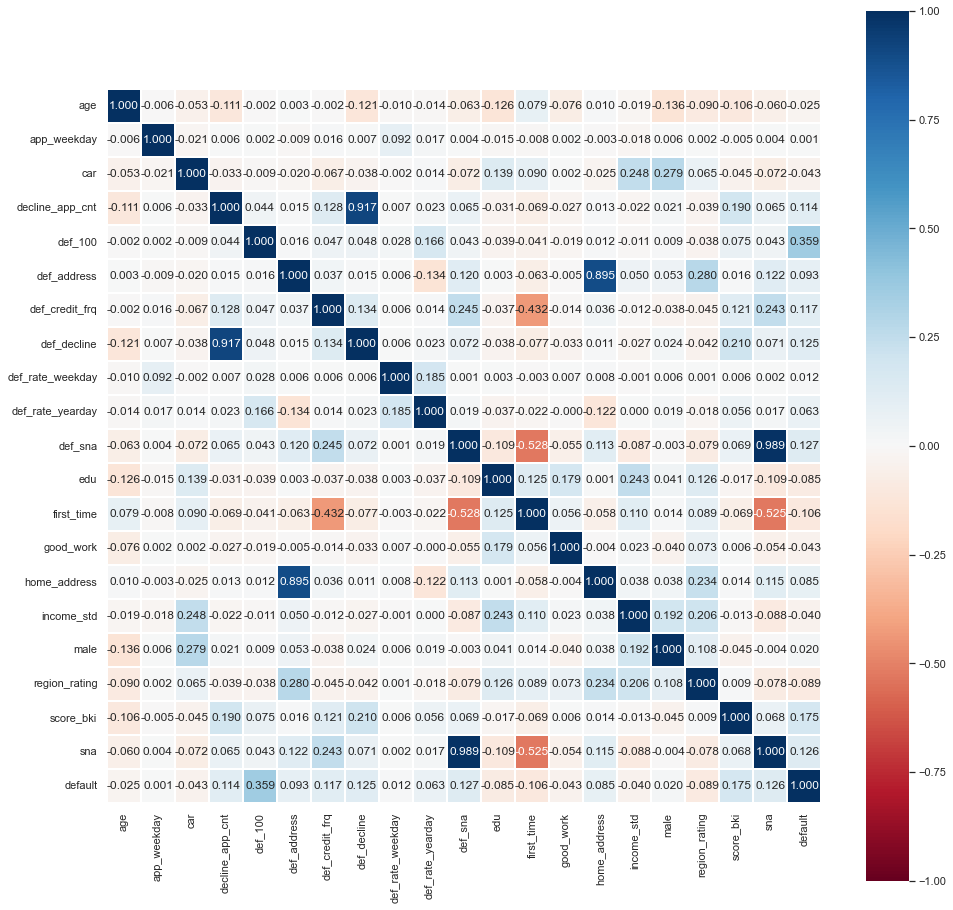

In [806]:
heatmap(to_drop, dd=train)

In [810]:
test_roc(to_drop, dd=train, test_name='2.12 sna')

results                                            vectors
start           0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work    0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100     0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates       0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu         0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male        0.658109  [decline_app_cnt, age, home_address, bki_reque...
2.6 age         0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.5 NO car      0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.6 no decline  0.687019  [decline_app_cnt, age, home_address, bki_reque...
-defage +car    0.727320  [decline_app_cnt, age, home_address, def_decli...
2.8 address     0.728020  [decline_app_cnt, age, home_address, def_decli...
2.11 income     0.804547  [decline_app_cnt, age, home_address, def_decli...
2.12 sna        0.831354  [decline_app_cnt, age, home_address, def_decli...

<a id='3'></a>
# 3. Конструирование новых признаков-векторов.
<a href='#0'> Содержание </a>

<a id='31'></a>
## 3.1 Применение пропорциональной и экспоненциальной шкалы уровня образованности **education**.
<a href='#0'> Содержание </a>


education  default_rate
ACD        291      0.041237
GRD      35246      0.090402
PGR       1865      0.064439
SCH      57998      0.150592
UGR      14748      0.131520

Список значений: ['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


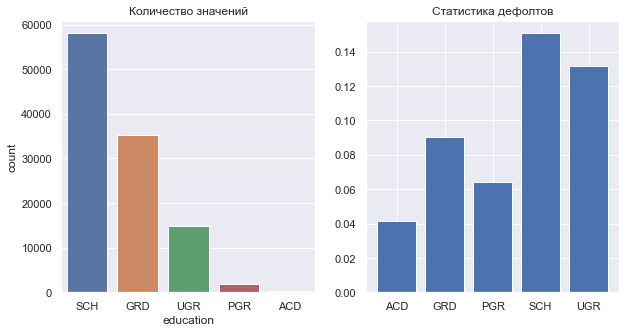

In [819]:
vector1, vector2 ='education', 'edu'
obj_stat(vector1)

In [820]:
data['def_edu'] = data.education.map(def_rate_count(vector1))
train=data[data.test == 0]

In [821]:
edu2 = {
        'ACD': 1,
        'PGR': 1/1.5,
        'GRD': 1/2.25,
        'UGR': 1/3.375,
        'SCH': 1/5.0625,
        }

In [824]:
data['edu15'] = data.education.map(edu2)
train=data[data.test == 0]

In [833]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'def_age', 'age_std', 'car_type',
           'decline_frq', 'decline', 'def_dec_frq',
           'bki_request_cnt', 'credit_frq',
           'def_history', 'score_bki_std',
           'def_address_home', 'def_address_work', 'foreign_passport',
           'def_region', 'income', 'sna', 'def_edu','edu15']

vectors0          vectors1          vectors2      vectors3
0          age_std        credit_frq       def_history          test
1      app_yearday           decline        def_region  work_address
2     app_yearweek       decline_frq           edu_nan              
3             bins  def_address_home  foreign_passport              
4  bki_request_cnt  def_address_work            income              
5         car_type           def_age     score_bki_std              
6        client_id       def_dec_frq               sna

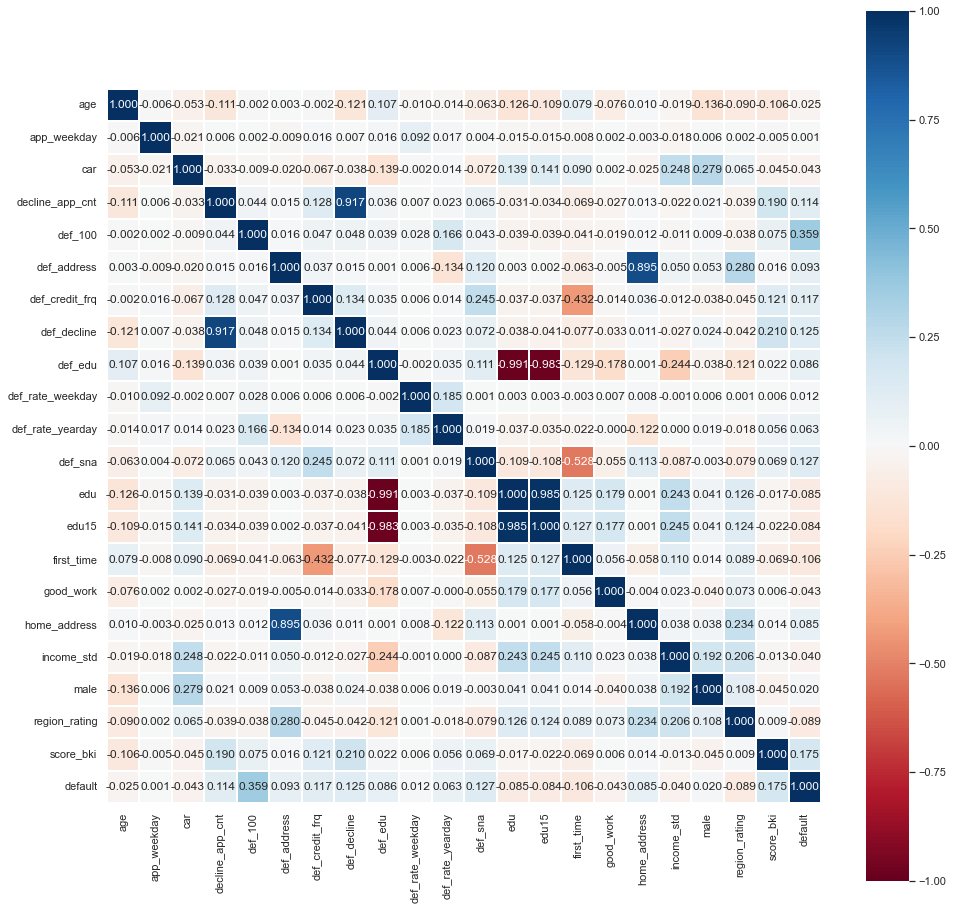

In [825]:
heatmap(to_drop, dd=train)

In [1]:
test_roc(to_drop, dd=train)

NameError: name 'test_roc' is not defined

результата нет....

<a id='32'></a>
## 3.2 Интергрированный признак "уровень личностного развития": совмещение **car_type**, **foreign_passport**, **good_work** и **region_rating**. Чем выше уровень развития, тем дефолтов меньше?
<a href='#0'> Содержание </a>

Среди векторов есть много странных, имеющих или слабую корреляцию, или вообще кажутся избыточными. Тем не менее, их же сюда включили не просто так, а потому что кто-то решил, что они имеют значениее. И я с этим тезиом очень-очень согласен. Надо просто понять их смысл.

In [835]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'test', 'bins', 'def_100',
       'app_weekday', 'app_yearweek', 'app_yearday', 'def_rate_weekday',
       'def_rate_yearday', 'edu_nan', 'edu', 'male', 'def_age', 'age_std',
       'decline', 'decline_frq', 'def_decline', 'def_dec_frq', 'credit_frq',
       'def_credit_frq', 'def_history', 'def_address_home', 'def_address_work',
       'def_address', 'def_region', 'income_std', 'def_sna', 'def_edu',
       'edu15'],
      dtype='object')

In [836]:
lst = ['car', 'car_type', 'good_work', 'foreign_passport', 'region_rating', target]
train[lst].corr()

car  car_type  good_work  foreign_passport  \
car               1.000000  0.697939   0.002027          0.107568   
car_type          0.697939  1.000000   0.017521          0.145807   
good_work         0.002027  0.017521   1.000000          0.046361   
foreign_passport  0.107568  0.145807   0.046361          1.000000   
region_rating     0.064685  0.104110   0.073041          0.255456   
default          -0.043161 -0.057484  -0.043361         -0.066718   

                  region_rating   default  
car                    0.064685 -0.043161  
car_type               0.104110 -0.057484  
good_work              0.073041 -0.043361  
foreign_passport       0.255456 -0.066718  
region_rating          1.000000 -0.089035  
default               -0.089035  1.000000

Empty DataFrame
Columns: []
Index: []

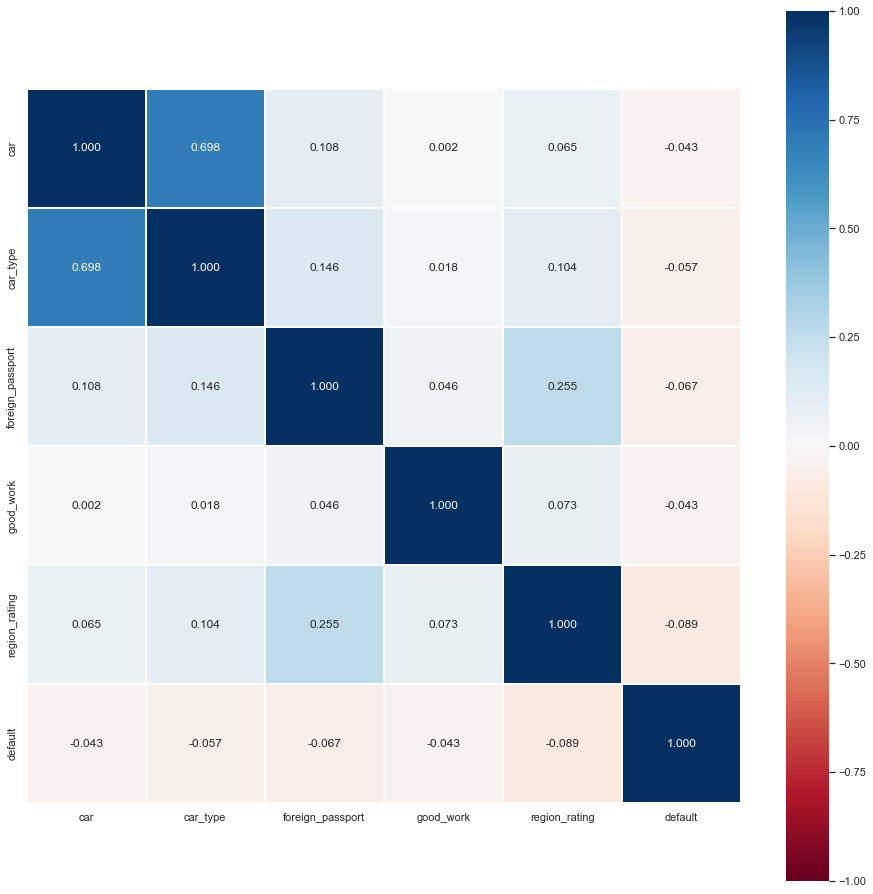

In [837]:
heatmap([], dd=train[lst])

О чем можно подумать, когда вы рассказываете о "наличие машины", "наличие иностранной марки машины", "наличие хорошей работы", "наличие загранпаспорта" (актуально для РФ - откуда сама база), "хороший район"? Видимо, это свидетельствует об определенном уровне достатка и меньшего риска дефолтов? Проверим это.

region_rating  default_rate
20            313      0.213592
30            434      0.190000
40          17947      0.169702
50          40981      0.136141
60          23999      0.128834
70           9304      0.092434
80          17170      0.073154

Список значений: [50 80 60 40 70 20 30]
В столбце      : 110148 всего значений
В столбце      : 0 пустых значений
В столбце      : 0 значений NaN


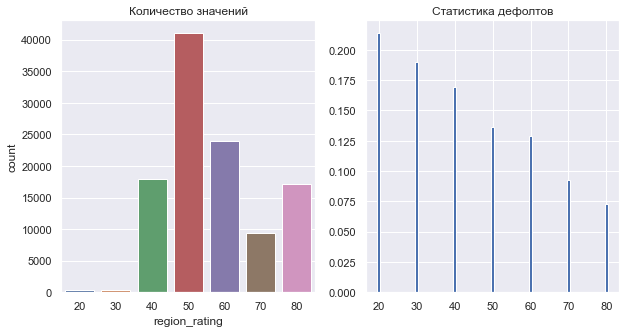

In [844]:
obj_stat(lst[4])

In [862]:
lst = ['client_id' ,'car', 'car_type', 'good_work', 'foreign_passport', 'region_rating', target]
life = data[lst]
lst = ['car', 'car_type', 'good_work', 'foreign_passport', 'region_rating']
for vector in lst:
    vec_name = 'def_'+vector
    life[vec_name]=life.loc[:,vector].map(def_rate_count(vector))
life.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             110148 non-null  int64  
 1   car                   110148 non-null  int64  
 2   car_type              110148 non-null  int64  
 3   good_work             110148 non-null  int64  
 4   foreign_passport      110148 non-null  int64  
 5   region_rating         110148 non-null  int64  
 6   default               73799 non-null   float64
 7   def_car               110148 non-null  float64
 8   def_car_type          110148 non-null  float64
 9   def_good_work         110148 non-null  float64
 10  def_foreign_passport  110148 non-null  float64
 11  def_region_rating     110148 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 15.0 MB


vectors0
0     life

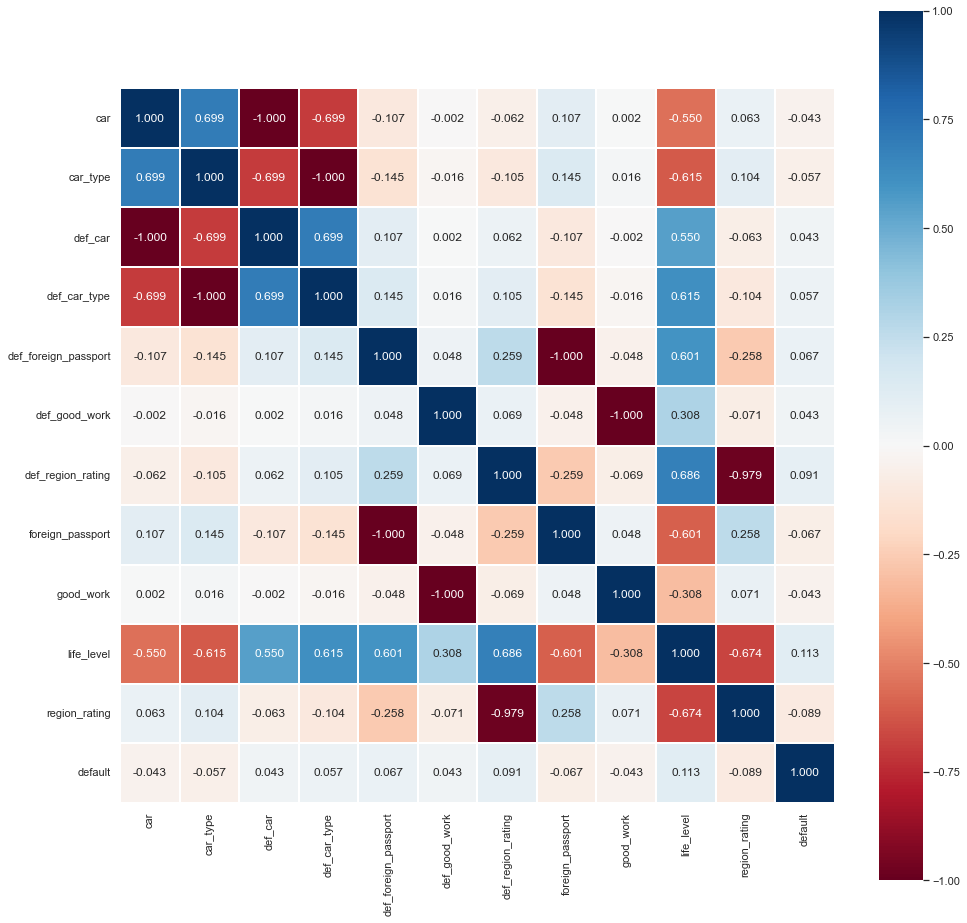

In [856]:
heatmap([], life)

In [863]:
life['life_level']=life.def_car+life.def_car_type+life.def_foreign_passport+life.def_good_work+life.def_region_rating

In [869]:
data['life_level'] = life['life_level']
train=data[data.test == 0]

In [899]:
to_drop = ['test', 'work_address', 'client_id', 'bins', 'app_yearday', 'app_yearweek',
           'edu_nan', 'def_age', 'age_std', 'car_type',
           'decline_frq', 'decline', 'def_dec_frq',
           'bki_request_cnt', 'credit_frq',
           'def_history', 'score_bki_std',
           'def_address_home', 'def_address_work', 'foreign_passport',
           'def_region', 'income', 'sna', 'def_edu', 'edu15',
           'region_rating', 'car', 'good_work', 'income_std']

vectors0          vectors1          vectors2       vectors3  \
0          age_std         client_id       def_dec_frq      good_work   
1      app_yearday        credit_frq           def_edu         income   
2     app_yearweek           decline       def_history     income_std   
3             bins       decline_frq        def_region  region_rating   
4  bki_request_cnt  def_address_home             edu15  score_bki_std   
5              car  def_address_work           edu_nan            sna   
6         car_type           def_age  foreign_passport           test   

       vectors4  
0  work_address  
1                
2                
3                
4                
5                
6

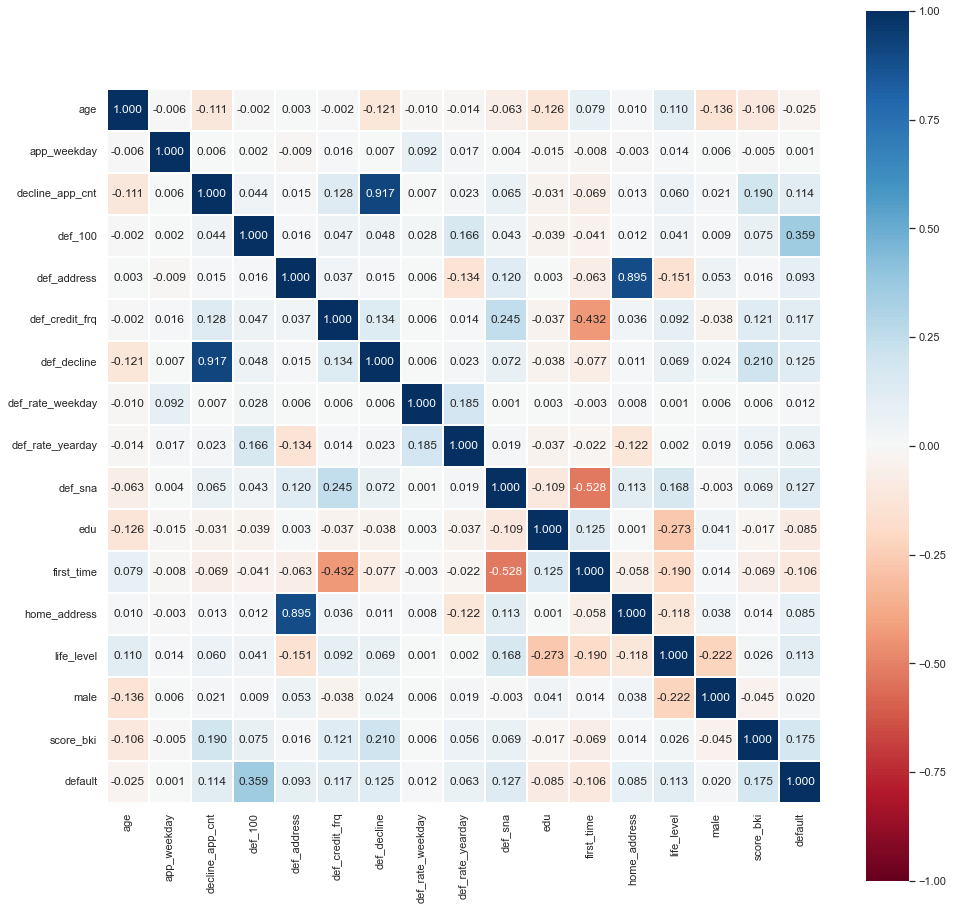

In [889]:
heatmap(to_drop, dd=train)

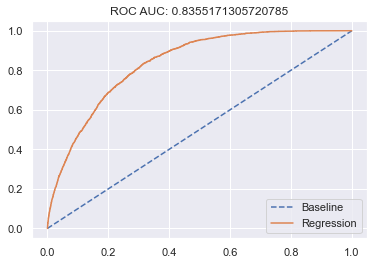

vectors0          vectors1   vectors2
0              age  def_rate_weekday       male
1      app_weekday  def_rate_yearday  score_bki
2  decline_app_cnt           def_sna           
3          def_100               edu           
4      def_address        first_time           
5   def_credit_frq      home_address           
6      def_decline        life_level

In [900]:
test_roc(to_drop, dd=train)

In [898]:
display_results('')

                 results                                            vectors
start           0.596664  [decline_app_cnt, age, first_time, home_addres...
start - work    0.596752  [decline_app_cnt, age, first_time, home_addres...
2.1 def_100     0.655999  [decline_app_cnt, age, first_time, home_addres...
2.2 dates       0.657476  [decline_app_cnt, age, first_time, home_addres...
2.3 edu         0.657822  [decline_app_cnt, age, home_address, bki_reque...
2.4 male        0.658109  [decline_app_cnt, age, home_address, bki_reque...
2.6 age         0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.5 NO car      0.687019  [decline_app_cnt, age, home_address, bki_reque...
2.6 no decline  0.687019  [decline_app_cnt, age, home_address, bki_reque...
-defage +car    0.727320  [decline_app_cnt, age, home_address, def_decli...
2.8 address     0.728020  [decline_app_cnt, age, home_address, def_decli...
2.11 income     0.804547  [decline_app_cnt, age, home_address, def_decli...
2.12 sna    

In [905]:
final = display_results('vectors')['+life -good']
display(sorted(final))

['age',
 'app_weekday',
 'decline_app_cnt',
 'def_100',
 'def_address',
 'def_credit_frq',
 'def_decline',
 'def_rate_weekday',
 'def_rate_yearday',
 'def_sna',
 'edu',
 'first_time',
 'home_address',
 'life_level',
 'male',
 'score_bki']

<a id='4'></a>
# 4. Подготовка данных для модели.  Моделирование с помощью LogisticRegression.
<a href='#0'> Содержание </a>

In [ ]:
# блок для импорта данных на Каггле
path = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [14]:
# блок для импорта данных локально
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
# блок для объединения в единый датасет
train['test'] = 0
test['test'] = 1
data = train.append(test)
data = data.astype({'test': 'int8'})  # изменяю тип, чтобы по типу отсеивать этот вектор (хитрость такая)
train = data[data.test == 0]
target = 'default'

In [12]:
prepare()

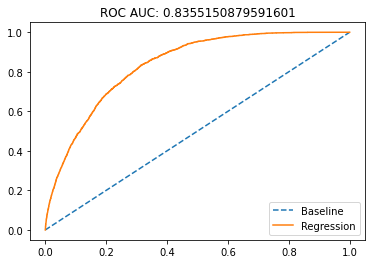

vectors0          vectors1   vectors2
0              age  def_rate_weekday       male
1      app_weekday  def_rate_yearday  score_bki
2  decline_app_cnt           def_sna           
3          def_100               edu           
4      def_address        first_time           
5   def_credit_frq      home_address           
6      def_decline        life_level

In [13]:
test_roc([],dd=train)

In [14]:
from sklearn.metrics import classification_report

<a id='5'></a>
# 5. Выбор и сравнение методов прогнозирования. Подбор и оценка гиперпараметров.
<a href='#0'> Содержание </a>

Для начала, объявим переменные и необходимые действия для дальнейшей работы

In [16]:
# разобъем датасет на переменные
x = train.drop(target, axis=1)
y = train.loc[:, target]

# Делим переменные на тренировочную и валидационную части 70/30. Тренируем модель (рандом - рандомный)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=423)

<a id='51'></a>
## 5.1 LogisticRegression
<a href='#0'> Содержание </a>

### RandomizedSearchCV

In [21]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=423) # solver='saga',
logistic.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 423,
 'solver': 'lbfgs',
 'tol': 0.01,
 'verbose': 0,
 'warm_start': False}

In [26]:
# параметры для случайного перебора
penalty=['elasticnet', 'l1', 'l2', 'none']
c = uniform(loc=0, scale=4)
param_dist = {
              'penalty': penalty,
              'C': c,
              }

In [27]:
#distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1']) # penalty=['l2', 'l1']
log_rs = RandomizedSearchCV(logistic, param_dist,
                            n_iter = 100,
                            cv = 3,
                            verbose = 1,
                            n_jobs=-1,
                            random_state=423)
search = log_rs.fit(x_train, y_train)
search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/irenaradzevich/Documents/sergei_dev/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/irenaradzevich/Documents/sergei_dev/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/irenaradzevich/Documents/sergei_dev/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/irenaradzevich/Documents/sergei_dev/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

{'C': 0.10722694862289073, 'penalty': 'l2'}

In [28]:
param_c = search.best_params_['C']
param_p = search.best_params_['penalty']

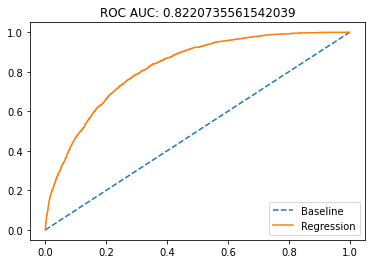

In [29]:
# теперь применяем гиперпараметры, найденные на предыдущем шаге
logistic = LogisticRegression(solver='saga',
                              C=param_c,
                              penalty='l1',
                              tol=1e-2,
                              max_iter=200,
                              random_state=423)

logistic.fit(x_train, y_train)

# берем вероятности
probs = logistic.predict_proba(x_test)[:,1]

plot_roc(y_test, probs)

К сожаленю, модель лучше не стала.

### GridSearchCV

In [17]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
param_dist = dict(C=C, penalty=penalty)

logistic = LogisticRegression()
logistic.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
log_gs = GridSearchCV(logistic, param_dist, cv=5, verbose=0)
search = log_gs.fit(x_train, y_train)

search.best_params_

{'C': 59.94842503189409, 'penalty': 'l2'}

In [18]:
param_c = search.best_params_['C']
param_p = search.best_params_['penalty']
param_c, param_p

(59.94842503189409, 'l2')

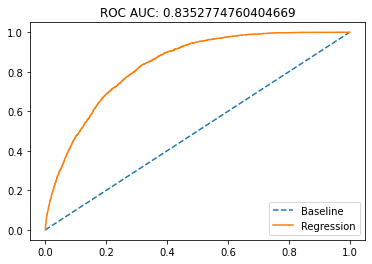

In [21]:
# теперь применяем гиперпараметры, найденные на предыдущем шаге
logistic = LogisticRegression(random_state=423, C=param_c, penalty='l2')
logistic.fit(x_train, y_train)

# берем вероятности
probs = logistic.predict_proba(x_test)[:,1]

plot_roc(y_test, probs)

А тут у нас практически повторение результата базовых настроек модели. Тоже не удача.

In [22]:
y_pred = logistic.predict(x_test)

In [25]:
target_names = ['class 0', 'class 1' ]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.89      0.98      0.93     19269
     class 1       0.55      0.19      0.28      2871

    accuracy                           0.87     22140
   macro avg       0.72      0.58      0.61     22140
weighted avg       0.85      0.87      0.85     22140



<a id='52'></a>
## 5.2 RandomForest.
<a href='#0'> Содержание </a>

In [26]:
from sklearn.ensemble import RandomForestClassifier

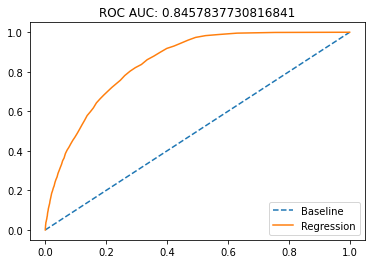

In [27]:
model_rfc = RandomForestClassifier(random_state=423)
model_rfc.fit(x_train, y_train)

# берем вероятности
probs = model_rfc.predict_proba(x_test)[:,1]

plot_roc(y_test, probs)

In [29]:
y_pred = model_rfc.predict(x_test)

In [30]:
target_names = ['class 0', 'class 1' ]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.89      0.98      0.93     19269
     class 1       0.58      0.16      0.25      2871

    accuracy                           0.88     22140
   macro avg       0.73      0.57      0.59     22140
weighted avg       0.85      0.88      0.84     22140



Перспективно! 84,57%

### Метод главных компонент

Смысл в том, чтобы уменьшить размерность. Правда, у меня и так не много этих компонент. В общем, ожидаемо, метод тут не улучшит результат.

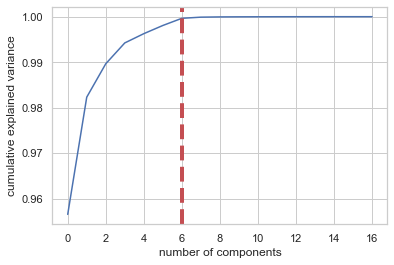

None

Cumulative Variance Ratio  Explained Variance Ratio
0                   0.956520                  0.956520
1                   0.982301                  0.025781
2                   0.989645                  0.007344
3                   0.994232                  0.004587
4                   0.996267                  0.002035
5                   0.998067                  0.001800
6                   0.999645                  0.001578
7                   0.999898                  0.000253
8                   0.999953                  0.000054
9                   0.999973                  0.000020

In [931]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=17)  # от 0 до 15 (макс = количеств анаших признаков)
pca_test.fit(x_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))


Предлагается 6 компонент.

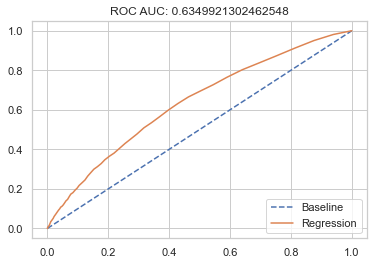

In [936]:
pca = PCA(n_components=6)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

model_rfc_pca = RandomForestClassifier(random_state=423)
model_rfc_pca.fit(x_train_pca, y_train)

# берем вероятности
probs_pca = model_rfc_pca.predict_proba(x_test_pca)[:,1]

plot_roc(y_test, probs)

### RandomizedSearchCV
Попробуем теперь метод по сильнее. При помощи рандомного поиска протестируем дипазоны гиперпараметров, чтобы улучшить настройки оригинальной модели.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# разобъем датасет на переменные
x = train.drop(target, axis=1)
y = train.loc[:, target]

# Делим переменные на тренировочную и валидационную части 70/30. Тренируем модель (рандом - рандомный)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=423)


model_rfc = RandomForestClassifier(random_state=423)
model_rfc.fit(x_train, y_train)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
rs = RandomizedSearchCV(model_rfc,
                        param_dist,
                        n_iter = 100,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)
rs.fit(x_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 800,
 'min_samples_split': 28,
 'min_samples_leaf': 12,
 'max_features': 'sqrt',
 'max_depth': 14,
 'bootstrap': True}

Есть уже и лучшие значения парметров, но может быть они не единственные? Чтобы это попробовать выяснить - построим графики.

In [38]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
    'mean_fit_time',
    'std_fit_time',
    'mean_score_time',
    'std_score_time',
    'params',
    'split0_test_score',
    'split1_test_score',
    'split2_test_score',
    'std_test_score'],
    axis=1)

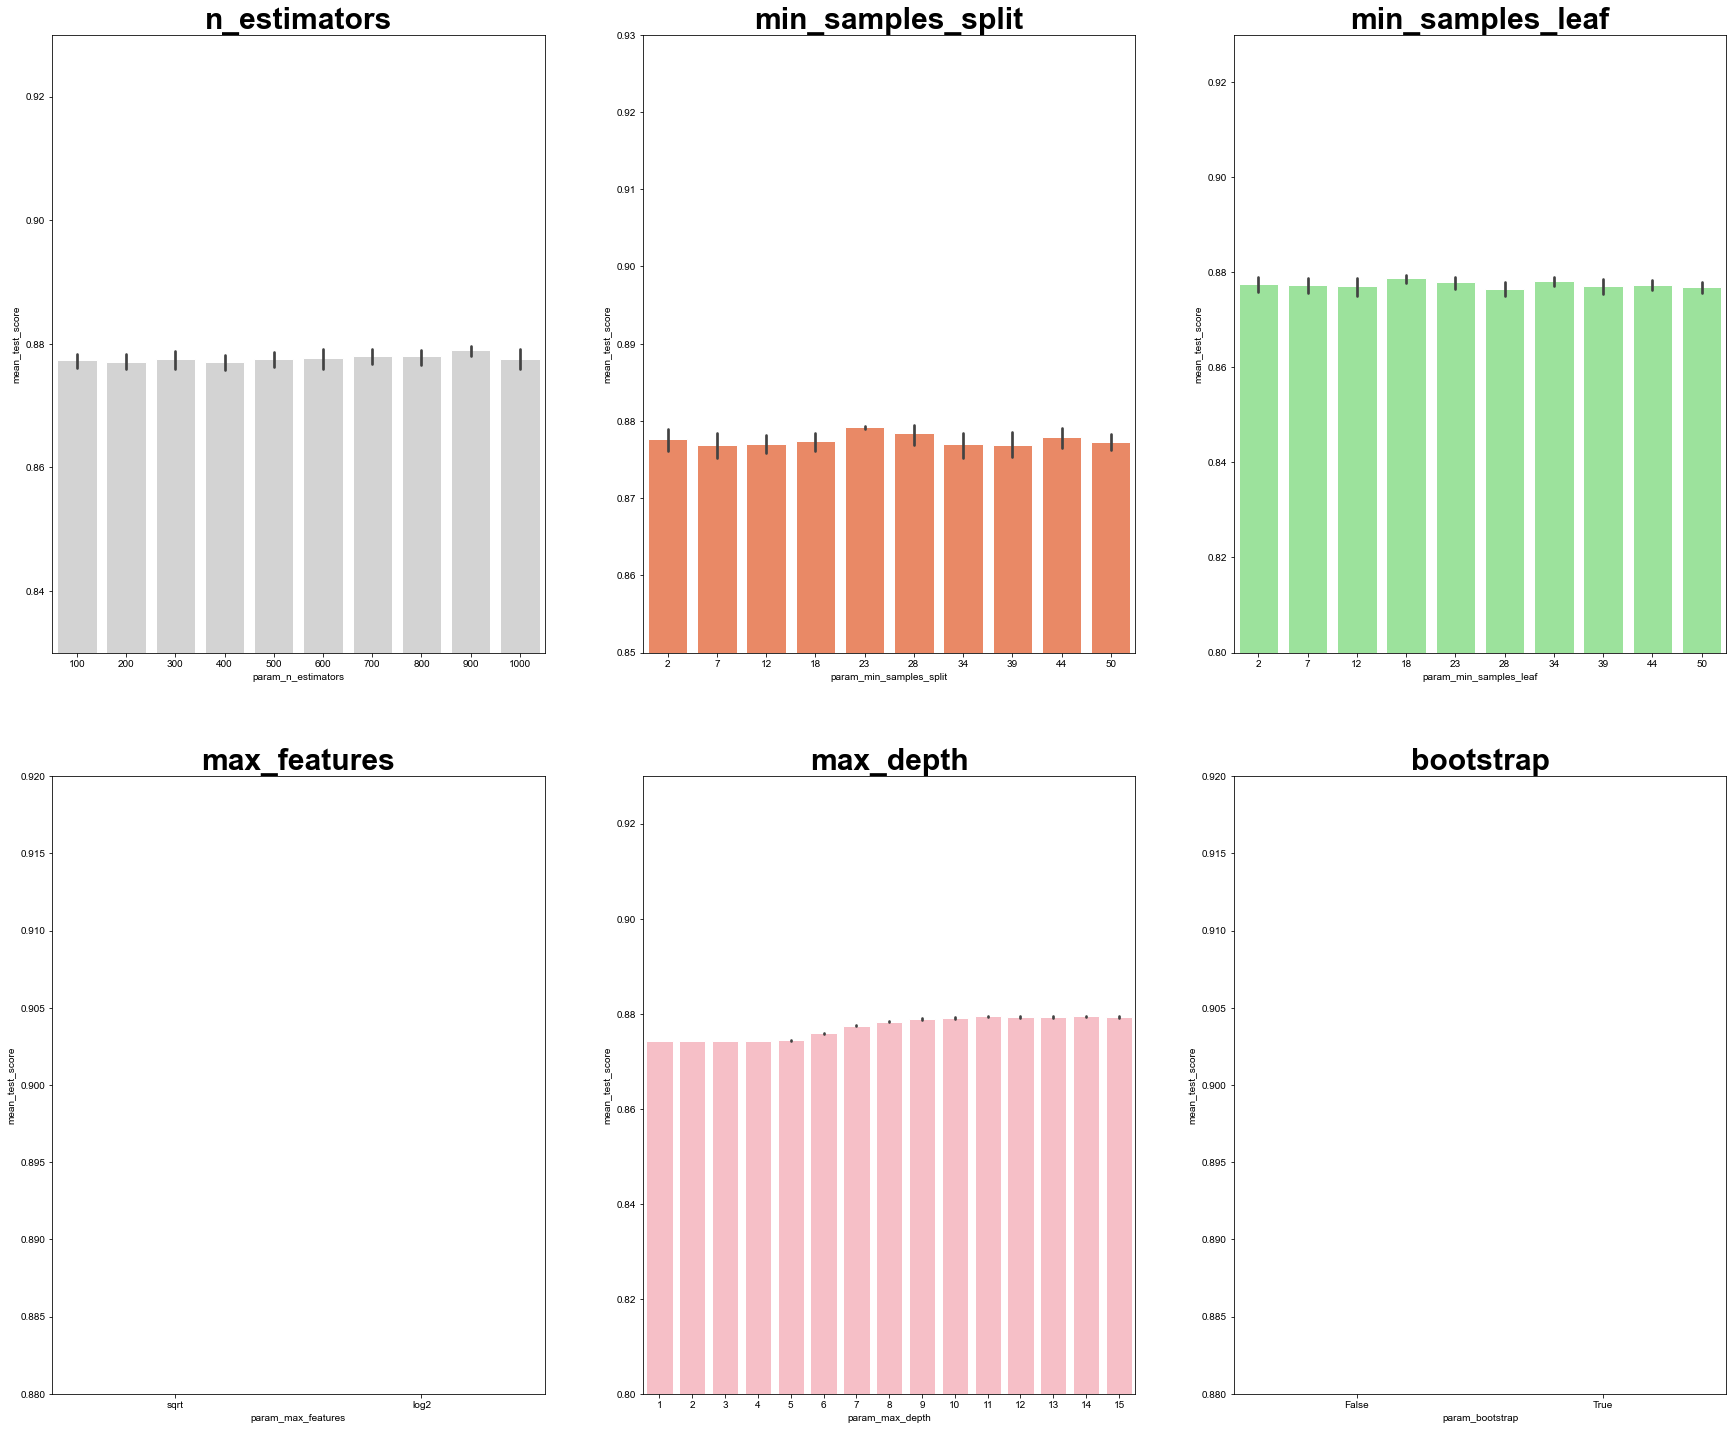

In [40]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Похоже, параметры не имеют много пиков, и полученные "лучшие параметры" - единственно интересные для применения.

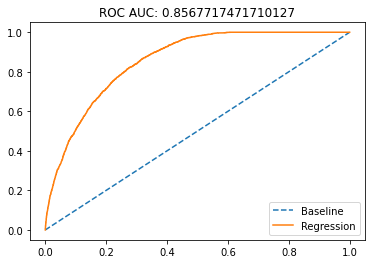

In [31]:

# попытка №2 уже с параметрами
model_rfc_2 = RandomForestClassifier(random_state=423,
                                     n_estimators=800,
                                     min_samples_split=28,
                                     min_samples_leaf=12,
                                     max_features='sqrt',
                                     max_depth=14,
                                     bootstrap=True)
model_rfc_2.fit(x_train, y_train)

# берем вероятности
probs = model_rfc_2.predict_proba(x_test)[:,1]

plot_roc(y_test, probs)

Ну, тут пришел в воссторг. Оказалось, что целевую метрику лможно было еще улучшить!!! Но воссторг был не долгим. Оказалось, нужно учитывать и другие метрики, а там не все так прекрасно:

In [32]:
y_pred = model_rfc_2.predict(x_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

     class 0       0.88      0.99      0.93     19269
     class 1       0.66      0.11      0.19      2871

    accuracy                           0.88     22140
   macro avg       0.77      0.55      0.56     22140
weighted avg       0.85      0.88      0.84     22140



Получается, нам нужно точнее предсказывать дефолты. Чтобы это попытаться сделать - утроим класс 1 и обрежем класс 0

In [54]:
# попытка №3
# разобъем датасет на переменные
tr_df = train[train.default == 1]   # все дефолтные
tr_g = train[train.default == 0]    # все не дефолтные
tr_g60, tr_g40 = train_test_split(tr_g, test_size=0.40, random_state=423) # отрежу оставлю 60%

tr = tr_g60.append(tr_df)   # добавлю дефолтные
tr = tr.append(tr_df)       # еще раз добавлю дефолтные
tr = tr.append(tr_df)       # еще раз добавлю дефолтные

# Итого дефолтные увеличились в два раза, не дофолтные - уменьшились на 30% итоговое соотношение 3:4 а не 1:7
tr.default.value_counts()

0.0    38656
1.0    28116
Name: default, dtype: int64

In [55]:

x = tr.drop(target, axis=1)
y = tr.loc[:, target]

# Делим переменные на тренировочную и валидационную части 70/30. Тренируем модель (рандом - рандомный)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=423)


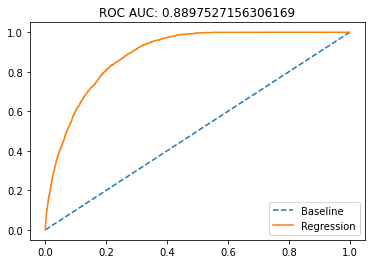

In [56]:
model_rfc_2 = RandomForestClassifier(random_state=423,
                                     n_estimators=800,
                                     min_samples_split=28,
                                     min_samples_leaf=12,
                                     max_features='sqrt',
                                     max_depth=14,
                                     bootstrap=True)
model_rfc_2.fit(x_train, y_train)

# берем вероятности
probs = model_rfc_2.predict_proba(x_test)[:,1]

plot_roc(y_test, probs)

In [48]:
y_pred = model_rfc_2.predict(x_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.83      0.87      0.85     11564
     class 1       0.71      0.64      0.68      5656

    accuracy                           0.80     17220
   macro avg       0.77      0.76      0.76     17220
weighted avg       0.79      0.80      0.79     17220



Теперь мы отлавливаем 64% дефолтов, тогда как начинали с 11%. При этом мы не значительно меньше угадываем недефолты, а roc_auc даже еще подрасла!

<a id='6'></a>
# 6. Моделирование, подготовка к подаче ответа.
<a href='#0'> Содержание </a>

In [58]:
# вариант "A"
# балансирую классы
train=data[data.test ==0]

tr_df = train[train.default == 1]   # все дефолтные
tr_g = train[train.default == 0]    # все не дефолтные
tr_g60, tr_g40 = train_test_split(tr_g, test_size=0.40, random_state=423) # отрежу оставлю 60%

tr = tr_g60.append(tr_df)   # добавлю дефолтные
tr = tr.append(tr_df)       # еще раз добавлю дефолтные
tr = tr.append(tr_df)       # еще раз добавлю дефолтные
# 0,61

x = tr.drop(target, axis=1)
y = tr.loc[:, target]

In [75]:
# Вариант "В"
# повторим но без балансировки
train=data[data.test ==0]
# 0,616

x = train.drop(target, axis=1)
y = train.loc[:, target]

In [76]:
# Вариант "С"
# повторим без балансировки, но удалю свой самый лучший вектор - принесший с лучший результат в самом начале
# но он же и самое необычное решение
train=data[data.test ==0]
train = train.drop('def_100', axis=1)
# 72,5

x = train.drop(target, axis=1)
y = train.loc[:, target]

In [83]:
# Вариант "D"
# удалил другой хороший вектор, но это ухудшло модель
#
train=data[data.test ==0]
train = train.drop(['def_100', 'life_level'], axis=1)
# 0,70

x = train.drop(target, axis=1)
y = train.loc[:, target]

In [84]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               73799 non-null  int64  
 1   app_weekday       73799 non-null  int64  
 2   decline_app_cnt   73799 non-null  int64  
 3   def_address       73799 non-null  float64
 4   def_credit_frq    73799 non-null  float64
 5   def_decline       73799 non-null  float64
 6   def_rate_weekday  73799 non-null  float64
 7   def_rate_yearday  73799 non-null  float64
 8   def_sna           73799 non-null  float64
 9   edu               73799 non-null  float64
 10  first_time        73799 non-null  int64  
 11  home_address      73799 non-null  int64  
 12  male              73799 non-null  int64  
 13  score_bki         73799 non-null  float64
 14  test              73799 non-null  int8   
dtypes: float64(8), int64(6), int8(1)
memory usage: 8.5 MB


In [85]:
x_sub = data[data.test == 1].drop(['def_100', 'life_level', target], axis=1)
x_sub.test = 0
x_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 0 to 36348
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               36349 non-null  int64  
 1   app_weekday       36349 non-null  int64  
 2   decline_app_cnt   36349 non-null  int64  
 3   def_address       36349 non-null  float64
 4   def_credit_frq    36349 non-null  float64
 5   def_decline       36349 non-null  float64
 6   def_rate_weekday  36349 non-null  float64
 7   def_rate_yearday  36349 non-null  float64
 8   def_sna           36349 non-null  float64
 9   edu               36349 non-null  float64
 10  first_time        36349 non-null  int64  
 11  home_address      36349 non-null  int64  
 12  male              36349 non-null  int64  
 13  score_bki         36349 non-null  float64
 14  test              36349 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 4.4 MB


In [61]:
model_rfc_2 = RandomForestClassifier(random_state=423,
                                     n_estimators=800,
                                     min_samples_split=28,
                                     min_samples_leaf=12,
                                     max_features='sqrt',
                                     max_depth=14,
                                     bootstrap=True)

In [86]:
model_rfc_2.fit(x, y)

RandomForestClassifier(max_depth=14, max_features='sqrt', min_samples_leaf=12,
                       min_samples_split=28, n_estimators=800,
                       random_state=423)

In [87]:
y_sub = model_rfc_2.predict_proba(x_sub)[:,1]

In [88]:
sub = pd.read_csv('test.csv')

sub['default']=y_sub

sub = sub[['client_id', 'default']]

In [89]:
sub.to_csv('submission_D.csv', index=False)

<a id='7'></a>
# 7. ВЫВОДЫ, наблюдения и комментарии.
<a href='#0'> Содержание </a>

1. Я доволен, что добрался до финиша! Не преувеличиваю. Это я так говорю, осознавая, сколько удалось сделать. Прежде всего, мне было интересно работать с этими данными, но их оказалось очень много. Так что я потратил огромное количество времени и сил. Тем не менее - не жалею. Также я неожиданно не сложно освоил (недеюсь) гиперпараметры и их подбор. Учитывая, что результат от этого действия действительно улучшился - я вообще в восторге.
2. Я сознательно сконцентрировался на целевой метрике ROC_AUC. Хотя я понимаю, что когда метрика становится целевым параметром, весь процесс может потерять суть и вообще ценность. Но я считаю, это такая тренировка, которая просто оттачивает навыки. В реальной работе будет надо внимательно выбирать метрики и стараться контролировать сам процесс. Кроме того, распыление на несколько метрик только отнимет силы, но не поможет достигнуть результатов. Это я пишу до того, как загружу ответ (submission) на площадку.
3. Что касается самой задачи. Несмотря на огромный интерес, все же видна ее академичность. Реальность кредитного отдела - посчитать не вероятность дефолта, а пердельную сумму, которую можно выдать до порога "вероятного" дефлолта. Также надо понимать, что дефолт дефолту рознь. Можно просрочить выплату, а можно - вообще стать не кредитоспособным. Это тоже сейчас учитывают при построении модели принятия решения по кредиту.
4. Неудалось. Я все же планировал применить больше моделей. Полдсмотрел в других решениях. Но к сожалению, не смог разобраться как их импортировать. Работал я локально. Задам вопрсо по этой теме, наверное, попозже. В частности интересна была бы какая-нибудь модель градиентного спуска.
5. Неудалось. По условиям соревнования, предлагалось создать команду и выступать командой. К сожалению, на призыв откликнулся только один человек, Сергей Фролов (serfrol - на  Каггле). Далее, мы как-то не смогли организовать совместную работу, времени у Сергея, как я понял было мало до дедлайна. Вот мы и чуть-чуть общались, что-то обсуждали, и он захотел загружать ответ уже в среду, тогда как я еще не отрботал все, что хотел (гиперпараметры и другие модели). При этом я показал ему свой итоговый датасет (состав векторов) после EDA и рассказал, какие основные приемы я использовал. Возможно, кооперация тут чем-то была полезна. Такая вот скомканная работа в команде.

# P.S.
увы моя модель показала крайне плохой результат на тесте. Всего 0.61. Балансирование классов (вариант А) не помогло. Чего-то лучшего удалось добиться только исключением самого лучшего моего вектора "def_100" (вариант C).  Но я попробую показать, что моя модель не так безнадежна.

План такой. Считаю, что весь трейн - это все что у нас есть, и нет никакого теста. Разделю сразу train на новый train_t (train_train) и train_v (train_valid). Буду трансформировать их отдельно, но карты трансформаци (карты статистики дефолтов по группировке в исследуемом векторе) буду считать только по train_t. Причем, делить исходный train, я буду близко к исходной задаче - 70/30 train_test_valid

Второй этап, моделирую ситуацию, приближенную к реальности. В банке есть база данных (train_t) и в течение дня приходят новые заявки на кредит (train_v). На этом этапе деление исходного датасета будет не случайным образом, а строго по дате (возьму один или два последних дня, например). И снова применю трансформацию данных "без утечки".

Также попробую гиперпараметры и балансировку классов.

In [114]:
# блок для импорта данных локально
train2 = pd.read_csv('train.csv')
target = 'default'
# попытка в лоб, номер 1

In [115]:
train_t, train_v = train_test_split(train2, test_size=0.30, random_state=423)

In [116]:
prepare_train()

In [100]:
model_rfc_2 = RandomForestClassifier()

In [117]:
x = train_t.drop(target, axis=1)
y = train_t.loc[:, target]
model_rfc_2.fit(x,y)


RandomForestClassifier()

In [128]:
# попытка 2, подровняем классы
tr_df = train_t[train_t.default == 1]   # все дефолтные
tr_g = train_t[train_t.default == 0]    # все не дефолтные
tr_g60, tr_g40 = train_test_split(tr_g, test_size=0.40, random_state=423) # отрежу оставлю 60%

tr = tr_g60.append(tr_df)   # добавлю дефолтные
tr = tr.append(tr_df)       # еще раз добавлю дефолтные
tr = tr.append(tr_df)       # еще раз добавлю дефолтные
# 0,61

x = tr.drop(target, axis=1)
y = tr.loc[:, target]

In [129]:
model_rfc_2.fit(x,y)

RandomForestClassifier()

In [130]:
x_valid = train_v.drop(target, axis=1)
y_valid = train_v.loc[:, target]

In [119]:
x_valid.isna().sum()

age                 0
app_weekday         0
decline_app_cnt     0
def_100             0
def_address         0
def_credit_frq      0
def_decline         0
def_rate_weekday    0
def_rate_yearday    0
def_sna             0
edu                 0
first_time          0
home_address        0
life_level          0
male                0
score_bki           0
dtype: int64

In [131]:
proba = model_rfc_2.predict_proba(x_valid)[:,1]

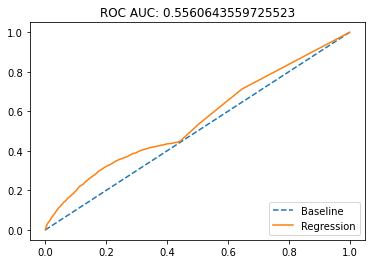

In [132]:
plot_roc(y_valid, proba)

In [133]:

y_pred = model_rfc_2.predict(x_valid)
target_names = ['class 0', 'class 1']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.88      0.89      0.89     19269
     class 1       0.23      0.21      0.22      2871

    accuracy                           0.80     22140
   macro avg       0.55      0.55      0.55     22140
weighted avg       0.80      0.80      0.80     22140



In [126]:
train_t.default.value_counts()[0]/train_t.default.value_counts()[1]

6.946315951392093

In [127]:
train_v.default.value_counts()[0]/train_v.default.value_counts()[1]

6.7115987460815045

Вывод такой
Модель действительно не может предсказать дефолты. Даже какое-никакое балансирование классов не помогает существенно - предсказано верно только 21%.

### второй этап

In [158]:
# блок для импорта данных локально
train2 = pd.read_csv('train.csv')
target = 'default'
# попытка в лоб, номер 1


In [159]:
train_v = train2[(train2.app_date == '30APR2014') | (train2.app_date == '29APR2014')]
train_t = train2[(train2.app_date != '30APR2014') & (train2.app_date != '29APR2014')]
train_t.shape, train_v.shape

((72843, 19), (956, 19))

In [160]:
prepare_train()
train_t.shape, train_v.shape

((72843, 17), (956, 17))

In [161]:
model_rfc_2 = RandomForestClassifier()

In [ ]:
x = train_t.drop(target, axis=1)
y = train_t.loc[:, target]

In [162]:
# попытка 2, подровняем классы
tr_df = train_t[train_t.default == 1]  # все дефолтные
tr_g = train_t[train_t.default == 0]  # все не дефолтные
tr_g60, tr_g40 = train_test_split(tr_g, test_size=0.40, random_state=423)  # отрежу оставлю 60%

tr = tr_g60.append(tr_df)  # добавлю дефолтные
tr = tr.append(tr_df)  # еще раз добавлю дефолтные
tr = tr.append(tr_df)  # еще раз добавлю дефолтные

x = tr.drop(target, axis=1)
y = tr.loc[:, target]

In [163]:
model_rfc_2.fit(x, y)

RandomForestClassifier()

In [164]:
x_valid = train_v.drop(target, axis=1)
y_valid = train_v.loc[:, target]

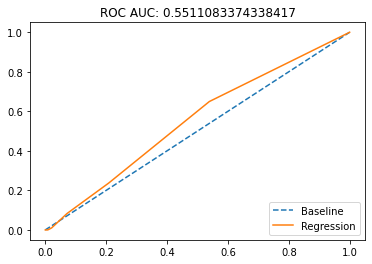

In [165]:
proba = model_rfc_2.predict_proba(x_valid)[:, 1]
plot_roc(y_valid, proba)

In [166]:
y_pred = model_rfc_2.predict(x_valid)
target_names = ['class 0', 'class 1']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.90      1.00      0.95       859
     class 1       0.00      0.00      0.00        97

    accuracy                           0.90       956
   macro avg       0.45      0.50      0.47       956
weighted avg       0.81      0.90      0.85       956



In [174]:
y_valid.sum()

97

Сдаюсь